<h2><center>Residential Energy Consumption Prediction using Regression and Ensemble Methods!</center></h2>

### Table of Contents

1. [Introduction](#1)

2. [Project Objectives](#2)

3. [Loading Libraries and Reading Data](#3)<br>
    a. [Loading Libraries](#31)<br>
    b. [Version of Installed Python Library](#32)<br>
    c. [Loading Data](#33)<br>

4. [Exploratory Data Analysis (EDA)](#4)<br>
    a. [Data Dimensionality](#41)<br>
    b. [Data Types](#42)<br>
    c. [Summary Statistics](#43)<br>
    d. [Check for Missing Values](#44)<br>
    e. [Explore Target Variable and Extract Important Features](#45)<br>
    f. [Detect Outliers and Anomalies](#46)<br>
    g. [Explore Additional Predictor Variables](#47)<br>
    
5. [Data Transformation and Preprocessing](#5)<br>
    a. [Data Transformation](#51)<br>
    &emsp;i. &nbsp;[Combining/Merging Predictor Features](#511)<br>
    &emsp;ii. [Combining/Merging Levels with Low Frequency in Discrete Predictor Features](#512)<br>
    
    b. [Data Preprocessing](#52)<br>
    &emsp;i.&ensp; [Removing Predictor Features with high 'Not Applicable' Values](#521)<br>
    &emsp;ii.&nbsp; [Removing Imputation Flags](#522)<br>
    &emsp;iii. [Removing Duplicate Features](#523)<br>
    &emsp;iv.&nbsp;[Removing Outliers](#524)<br>

6. [Feature Engineering](#6)<br>
    a. [Exploratory Feature Reduction](#61)<br>
    b. [Feature Selection](#62)<br>
    &emsp;i. &nbsp;[Find Features with Single Unique Value](#621)<br>
    &emsp;ii. [Find Collinear Features](#622)<br>
    &emsp;iii. [Find Features with Zero Importance using GBM](#623)<br>
    &emsp;iv.&nbsp;[Find Features with Low Importance](#624)<br>
    &emsp;v.&nbsp;[Removing Features](#625)<br>

7. [Model Development & Comparison](#7)<br>
    a. [Building Baseline Models with Default Params](#71)<br>
    b. [Hyperparameter Tuning & Model Comparison](#72)<br>
    c. [Model Evaluation on Unseen Data](#73)

<a id="1"></a>
### 1. Introduction

Every four years, [EIA](https://www.eia.gov/consumption/residential/about.php) administers the Residential Energy Consumption Survey (RECS) to a nationally representative sample of housing units across the United States to collect energy characteristics data on the housing unit, usage patterns, and household demographics. $^{1}$

This project focuses on 2009 RECS survey data which represents the 13th iteration of the RECS program. First conducted in 1978, the Residential Energy Consumption Survey is a national sample survey that collects energy-related data for housing units occupied as a primary residence and the households that live in them. 2009 data were collected from 12,083 households selected at random using a complex multistage, area-probability sample design. The sample represents 113.6 million U.S. households, the Census Bureau’s statistical estimate for all occupied housing units in 2009 derived from their American Community Survey (ACS). $^{1}$

<a id="2"></a>
### 2. Project objectives

This project utilizes applied machine learning methods, Regression as well as Ensemble methods, on the 2009 RECS dataset to achieve the following three objectives:

- __Description:__ Describing/Exploring the set of features with the strong statistical associations with target variable Annual Electricity Usage (in kWh)

- __Feature Selection:__ Showcasing different feature selection methods to select the most critical features for electricity consumption;

- __Prediction:__ – Applying different machine learning models to measure and compare predictive performance of the selected features


The target variable is "KWH" which stands for kilowatt-hour.

<a id="3"></a>
### 3. Loading Libraries and Reading Data
<a id="31"></a>
#### a. Loading Libraries
Let's start by importing the libraries we need

In [1]:
#!pip install --upgrade "pandas==2.2.2" "numpy==2.2.0" "scipy==1.13.0" --force-reinstall --quiet
#import os
#os.kill(os.getpid(), 9)  # Restart runtime


In [2]:
import pandas as pd

# 🩹 Restore deprecated methods for compatibility
if not hasattr(pd.DataFrame, 'append'):
    def _append(self, other, ignore_index=False, verify_integrity=False, sort=False):
        from pandas import concat, DataFrame
        if isinstance(other, dict): other = DataFrame([other])
        elif not isinstance(other, DataFrame): other = DataFrame(other)
        return concat([self, other], ignore_index=ignore_index, verify_integrity=verify_integrity, sort=sort)
    pd.DataFrame.append = _append

if not hasattr(pd.Index, '_format_flat'):
    pd.Index._format_flat = lambda self, include_name=False: self.tolist()



In [3]:
import pandas as pd
from pandas import set_option
from pandas import get_dummies
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import scipy.stats

from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
import sklearn
import warnings
warnings.filterwarnings("ignore")

from feature_selector import FeatureSelector

#XGBoost libraries
import xgboost as xgb

<a id="32"></a>
#### b. Version of Installed Python Library

For the purpose of reproducibility of this analysis, displaying the versions of installed libraries

In [4]:
import pandas as pd

def _append(self, other, ignore_index=False, verify_integrity=False, sort=False):
    from pandas import concat, DataFrame
    if isinstance(other, dict): other = DataFrame([other])
    elif not isinstance(other, DataFrame): other = DataFrame(other)
    return concat([self, other], ignore_index=ignore_index, verify_integrity=verify_integrity, sort=sort)

pd.DataFrame.append = _append


In [5]:
print('matplotlib: {}'.format(matplotlib.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('seaborn: {}'.format(sns.__version__))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('xgboost: {}'.format(xgb.__version__))


matplotlib: 3.10.0
sklearn: 1.6.1
seaborn: 0.13.2
pandas: 2.2.2
numpy: 2.0.2
xgboost: 3.0.2


<a id="33"></a>
#### c. Loading Data

In [6]:
DATA_PATH = 'data'
FILE_NAME = 'recs2009_public.csv'
df = pd.read_csv(os.path.join(DATA_PATH, FILE_NAME), encoding = 'utf-8-sig')

<a id="4"></a>
### 4. Exploratory Data Analysis (EDA)

In the EDA phase, we will perform initial investigations on the dataset to check the following:
- data dimensionality (or shape) alongwith observing first few observations of the dataset
- data types (whether categorical or numerical)
- generate summary statistics
- missing values
- explore our target variable _'KWH'_ and its possible predictors from the dataset
- detect outliers and anomalies
- explore additional predictor variables

<a id="41"></a>
#### a. Data Dimensionality

In [7]:
import pandas as pd

# Patch for broken IPython display in Colab
if not hasattr(pd.Index, '_format_flat'):
    pd.Index._format_flat = lambda self, include_name=False: self.tolist()


Let's start by glancing first few observations of the RECS dataset alongwith its dimensionality

In [8]:
# Set pandas to display all columns when printing DataFrames
# df.shape[1] gives the number of columns in the DataFrame
pd.options.display.max_columns = df.shape[1]


# Display the first 5 rows of the DataFrame
# Useful for getting a quick look at the data: column names, sample values, data types, etc.
df.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,AIA_Zone,METROMICRO,UR,KOWNRENT,CONDCOOP,YEARMADE,YEARMADERANGE,OCCUPYYRANGE,CONVERSION,ORIG1FAM,LOOKLIKE,NUMFLRS,NUMAPTS,WALLTYPE,ROOFTYPE,STUDIO,NAPTFLRS,STORIES,TYPEHUQ4,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,CELLAR,CRAWL,CONCRETE,BASEFIN,FINBASERMS,BASEHEAT,BASEHT2,PCTBSTHT,BASECOOL,BASECL2,PCTBSTCL,BASEUSE,ATTIC,ATTICFIN,FINATTRMS,ATTCHEAT,ATTCHT2,PCTATTHT,ATTCCOOL,ATTCCL2,PCTATTCL,ATTICUSE,PRKGPLC1,SIZEOFGARAGE,GARGLOC,GARGHEAT,GARGCOOL,PRKGPLC2,SIZEOFDETACH,OUTLET,ZKOWNRENT,ZCONDCOOP,ZYEARMADE,ZYEARMADERANGE,ZOCCUPYYRANGE,ZCONVERSION,ZORIG1FAM,ZLOOKLIKE,ZNUMFLRS,ZNUMAPTS,ZWALLTYPE,ZROOFTYPE,ZSTUDIO,ZNAPTFLRS,ZSTORIES,ZTYPEHUQ4,ZBEDROOMS,ZNCOMBATH,ZNHAFBATH,ZOTHROOMS,ZCELLAR,ZCRAWL,ZCONCRETE,ZBASEFIN,ZFINBASERMS,ZBASEHEAT,ZBASEHT2,ZPCTBSTHT,ZBASECOOL,ZBASECL2,ZPCTBSTCL,ZBASEUSE,ZATTIC,ZATTICFIN,ZFINATTRMS,ZATTCHEAT,ZATTCHT2,ZPCTATTHT,ZATTCCOOL,ZPCTATTCL,ZATTCCL2,ZATTICUSE,ZPRKGPLC1,ZSIZEOFGARAGE,ZGARGLOC,ZGARGHEAT,ZGARGCOOL,ZPRKGPLC2,ZSIZEOFDETACH,STOVEN,STOVENFUEL,STOVE,STOVEFUEL,OVEN,OVENFUEL,OVENUSE,OVENCLN,TYPECLN,MICRO,AMTMICRO,DEFROST,OUTGRILL,OUTGRILLFUEL,TOPGRILL,STGRILA,TOASTER,NUMMEAL,FUELFOOD,COFFEE,NUMFRIG,TYPERFR1,SIZRFRI1,REFRIGT1,ICE,AGERFRI1,ESFRIG,REPLCFRI,HELPFRI,HELPFRIY,TYPERFR2,SIZRFRI2,REFRIGT2,MONRFRI2,AGERFRI2,ESFRIG2,TYPERFR3,SIZRFRI3,REFRIGT3,MONRFRI3,AGERFRI3,ESFRIG3,SEPFREEZ,NUMFREEZ,UPRTFRZR,SIZFREEZ,FREEZER,AGEFRZR,REPLCFRZ,HELPFRZ,HELPFRZY,UPRTFRZR2,SIZFREEZ2,FREEZER2,AGEFRZR2,DISHWASH,DWASHUSE,AGEDW,ESDISHW,REPLCDW,HELPDW,HELPDWY,ZSTOVEN,ZSTOVENFUEL,ZSTOVE,ZSTOVEFUEL,ZOVEN,ZOVENFUEL,ZOVENUSE,ZOVENCLN,ZTYPECLN,ZMICRO,ZAMTMICRO,ZDEFROST,ZOUTGRILL,ZOUTGRILLFUEL,ZTOPGRILL,ZSTGRILA,ZTOASTER,ZNUMMEAL,ZFUELFOOD,ZCOFFEE,ZNUMFRIG,ZTYPERFR1,ZSIZRFRI1,ZREFRIGT1,ZICE,ZAGERFRI1,ZTYPERFR2,ZSIZRFRI2,ZREFRIGT2,ZMONRFRI2,ZAGERFRI2,ZTYPERFR3,ZSIZRFRI3,ZREFRIGT3,ZMONRFRI3,ZAGERFRI3,ZSEPFREEZ,ZNUMFREEZ,ZUPRTFRZR,ZSIZFREEZ,ZFREEZER,ZAGEFRZR,ZUPRTFRZR2,ZSIZFREEZ2,ZFREEZER2,ZAGEFRZR2,ZDISHWASH,ZDWASHUSE,ZAGEDW,CWASHER,TOPFRONT,WASHLOAD,WASHTEMP,RNSETEMP,AGECWASH,ESCWASH,REPLCCW,HELPCW,HELPCWY,DRYER,DRYRFUEL,DRYRUSE,AGECDRYER,TVCOLOR,TVSIZE1,TVTYPE1,CABLESAT1,COMBODVR1,DVR1,DIGITSTB1,PLAYSTA1,COMBOVCRDVD1,VCR1,DVD1,TVAUDIOSYS1,OTHERSTB1,TVONWD1,TVONWDWATCH1,TVONWE1,TVONWEWATCH1,TVSIZE2,TVTYPE2,CABLESAT2,COMBODVR2,DVR2,DIGITSTB2,PLAYSTA2,COMBOVCRDVD2,VCR2,DVD2,TVAUDIOSYS2,OTHERSTB2,TVONWD2,TVONWDWATCH2,TVONWE2,TVONWEWATCH2,TVSIZE3,TVTYPE3,CABLESAT3,COMBODVR3,DVR3,DIGITSTB3,PLAYSTA3,COMBOVCRDVD3,VCR3,DVD3,TVAUDIOSYS3,OTHERSTB3,TVONWD3,TVONWDWATCH3,TVONWE3,TVONWEWATCH3,COMPUTER,NUMPC,PCTYPE1,MONITOR1,TIMEON1,PCONOFF1,PCSLEEP1,PCTYPE2,MONITOR2,TIMEON2,PCONOFF2,PCSLEEP2,PCTYPE3,MONITOR3,TIMEON3,PCONOFF3,PCSLEEP3,INTERNET,INDIALUP,INDSL,INCABLE,INSATEL,INWIRELESS,PCPRINT,FAX,COPIER,WELLPUMP,DIPSTICK,SWAMPCOL,AQUARIUM,STEREO,NOCORD,ANSMACH,BATTOOLS,BATCHRG,CHRGPLGT,ELECDEV,ELECCHRG,CHRGPLGE,ZCWASHER,ZTOPFRONT,ZWASHLOAD,ZWASHTEMP,ZRNSETEMP,ZAGECWASH,ZDRYER,ZDRYRFUEL,ZDRYRUSE,ZAGECDRYER,ZTVCOLOR,ZTVSIZE1,ZTVTYPE1,ZCABLESAT1,ZCOMBODVR1,ZDVR1,ZDIGITSTB1,ZPLAYSTA1,ZCOMBOVCRDVD1,ZVCR1,ZDVD1,ZTVAUDIOSYS1,ZOTHERSTB1,ZTVONWD1,ZTVONWDWATCH1,ZTVONWE1,ZTVONWEWATCH1,ZTVSIZE2,ZTVTYPE2,ZCABLESAT2,ZCOMBODVR2,ZDVR2,ZDIGITSTB2,ZPLAYSTA2,ZCOMBOVCRDVD2,ZVCR2,ZDVD2,ZTVAUDIOSYS2,ZOTHERSTB2,ZTVONWD2,ZTVONWDWATCH2,ZTVONWE2,ZTVONWEWATCH2,ZTVSIZE3,ZTVTYPE3,ZCABLESAT3,ZCOMBODVR3,ZDVR3,ZDIGITSTB3,ZPLAYSTA3,ZCOMBOVCRDVD3,ZVCR3,ZDVD3,ZTVAUDIOSYS3,ZOTHERSTB3,ZTVONWD3,ZTVONWDWATCH3,ZTVONWE3,ZTVONWEWATCH3,ZCOMPUTER,ZNUMPC,ZPCTYPE1,ZMONITOR1,ZTIMEON1,ZPCONOFF1,ZPCSLEEP1,ZPCTYPE2,ZMONITOR2,ZTIMEON2,ZPCONOFF2,ZPCSLEEP2,ZPCTYPE3,ZMONITOR3,ZTIMEON3,ZPCONOFF3,ZPCSLEEP3,ZINTERNET,ZINDIALUP,ZINDSL,ZINCABLE,ZINSATEL,ZINWIRELESS,ZPCPRINT,ZFAX,ZCOPIER,ZWELLPUMP,ZDIPSTICK,ZSWAMPCOL,ZAQUARIUM,ZSTEREO,ZNOCORD,ZANSMACH,ZBATTOOLS,ZBATCHRG,ZCHRGPLGT,ZELECDEV,ZELECCHRG,ZCHRGPLGE,HEATHOME,DNTHEAT,EQUIPNOHEAT,FUELNOHEAT,EQUIPM,FUELHEAT,MAINTHT,EQUIPAGE,REPLCHT,HE

In [117]:
print(f"Shape of the dataset df_recs is {df.shape}") #rows, columns

Shape of the dataset df_recs is (12083, 430)


As can be seen above, RECS 2009 dataset consists of 12,083 observations and 940 features. Let's explore how many of these features are categorical vs numerical

<a id="42"></a>
#### b. Data Types

In [10]:
num_features = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(num_features))

cat_features = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(cat_features))

Number of Numerical features:  935
Number of Categorical features:  5


`df.info()` method prints a concise summary of a dataframe including count of index data type, number of columns. `df.describe()` method prints out the descriptive statistics including mean, median (i.e. Second Quartile, Q2 depicted by 50% in the summary table below), standard deviation, range, Q1 and Q3 quartile values. As can be seen below, RECS 2009 dataset consists of three different column data types:
- _float64_ data type with 50 columns
- _int64_ data type with 885 columns, and
- _object_ data type with 5 columns

The count of column data types is consistent with the count of numerical and categorical features we calculated above. Count of Numerical features we calculated above is actually sum of number of _float64_ and _int64_ data type columns i.e. (50 + 885 = 935).

The number of records, 12083 is consistent with what we found using `df.shape`. We don't have any NA values in the dataset.

In [11]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Columns: 940 entries, DOEID to DesignDBT1
dtypes: float64(50), int64(885), object(5)
memory usage: 86.7+ MB


<a id="43"></a>
#### c. Summary Statistics

In [119]:
# Generates descriptive statistics for numerical columns:
# count, mean, std, min, 25%, 50% (median), 75%, and max values
df.describe()


,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,AIA_Zone,KOWNRENT,CONDCOOP,YEARMADE,YEARMADERANGE,OCCUPYYRANGE,CONVERSION,NUMFLRS,NUMAPTS,WALLTYPE,ROOFTYPE,STUDIO,NAPTFLRS,STORIES,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,CELLAR,CRAWL,CONCRETE,BASEFIN,FINBASERMS,BASEHEAT,BASEHT2,PCTBSTHT,BASECOOL,BASECL2,BASEUSE,ATTIC,ATTICFIN,ATTCHEAT,ATTCCOOL,ATTICUSE,PRKGPLC1,SIZEOFGARAGE,GARGLOC,GARGHEAT,GARGCOOL,PRKGPLC2,SIZEOFDETACH,OUTLET,STOVEN,STOVENFUEL,STOVE,STOVEFUEL,OVEN,OVENFUEL,OVENUSE,OVENCLN,TYPECLN,MICRO,AMTMICRO,DEFROST,OUTGRILL,OUTGRILLFUEL,TOPGRILL,TOASTER,NUMMEAL,FUELFOOD,COFFEE,NUMFRIG,TYPERFR1,SIZRFRI1,REFRIGT1,ICE,AGERFRI1,ESFRIG,REPLCFRI,HELPFRI,TYPERFR2,SIZRFRI2,REFRIGT2,MONRFRI2,AGERFRI2,ESFRIG2,SEPFREEZ,NUMFREEZ,UPRTFRZR,SIZFREEZ,FREEZER,AGEFRZR,REPLCFRZ,HELPFRZ,DISHWASH,DWASHUSE,AGEDW,ESDISHW,REPLCDW,HELPDW,CWASHER,TOPFRONT,WASHLOAD,WASHTEMP,RNSETEMP,AGECWASH,ESCWASH,REPLCCW,HELPCW,DRYER,DRYRFUEL,DRYRUSE,AGECDRYER,TVCOLOR,TVSIZE1,TVTYPE1,CABLESAT1,COMBODVR1,DVR1,DIGITSTB1,PLAYSTA1,COMBOVCRDVD1,VCR1,DVD1,TVAUDIOSYS1,OTHERSTB1,TVONWD1,TVONWDWATCH1,TVONWE1,TVONWEWATCH1,TVSIZE2,TVTYPE2,CABLESAT2,COMBODVR2,DVR2,DIGITSTB2,PLAYSTA2,COMBOVCRDVD2,VCR2,DVD2,TVAUDIOSYS2,OTHERSTB2,TVONWD2,TVONWDWATCH2,TVONWE2,TVONWEWATCH2,TVSIZE3,TVTYPE3,CABLESAT3,COMBODVR3,DVR3,DIGITSTB3,PLAYSTA3,COMBOVCRDVD3,VCR3,DVD3,TVAUDIOSYS3,OTHERSTB3,TVONWD3,TVONWDWATCH3,TVONWE3,TVONWEWATCH3,COMPUTER,NUMPC,PCTYPE1,MONITOR1,TIMEON1,PCONOFF1,PCSLEEP1,PCTYPE2,MONITOR2,TIMEON2,PCONOFF2,PCSLEEP2,PCTYPE3,MONITOR3,TIMEON3,PCONOFF3,INTERNET,INDIALUP,INDSL,INCABLE,INSATEL,INWIRELESS,PCPRINT,FAX,COPIER,WELLPUMP,DIPSTICK,SWAMPCOL,AQUARIUM,STEREO,NOCORD,ANSMACH,BATTOOLS,BATCHRG,CHRGPLGT,ELECDEV,ELECCHRG,CHRGPLGE,HEATHOME,EQUIPM,FUELHEAT,MAINTHT,EQUIPAGE,REPLCHT,HELPHT,HEATOTH,EQUIPAUX,REVERSE,WARMAIR,STEAMR,PERMELEC,PIPELESS,ROOMHEAT,WOODKILN,CARRYEL,CARRYKER,CHIMNEY,FPFUEL,NGFPFLUE,USENGFP,RANGE,DIFEQUIP,EQMAMT,HEATROOM,THERMAIN,NUMTHERM,PROTHERM,AUTOHEATNITE,AUTOHEATDAY,TEMPHOME,TEMPGONE,TEMPNITE,MOISTURE,USEMOISTURE,NUMH2ONOTNK,NUMH2OHTRS,H2OTYPE1,FUELH2O,WHEATOTH,WHEATSIZ,WHEATAGE,WHEATBKT,HELPWH,AIRCOND,DNTAC,COOLTYPE,CENACHP,ACOTHERS,MAINTAC,AGECENAC,REPLCCAC,HELPCAC,ACROOMS,USECENAC,THERMAINAC,PROTHERMAC,AUTOCOOLNITE,AUTOCOOLDAY,TEMPHOMEAC,TEMPGONEAC,TEMPNITEAC,NUMBERAC,WWACAGE,ESWWAC,REPLCWWAC,HELPWWAC,USEWWAC,NUMCFAN,USECFAN,TREESHAD,NOTMOIST,USENOTMOIST,HIGHCEIL,CATHCEIL,SWIMPOOL,POOL,RECBATH,FUELTUB,LGT12,LGT12EE,LGT4,LGT4EE,LGT1,LGT1EE,NOUTLGTNT,LGTOEE,NGASLIGHT,INSTLCFL,HELPCFL,SLDDRS,DOOR1SUM,WINDOWS,TYPEGLASS,NEWGLASS,HELPWIN,ADQINSUL,INSTLINS,AGEINS,HELPINS,DRAFTY,INSTLWS,AGEWS,HELPWS,AUDIT,USEEL,USENG,USELP,USEFO,USEKERO,USEWOOD,USESOLAR,USEOTH,ELWARM,ELECAUX,ELCOOL,ELWATER,ELFOOD,ELOTHER,UGWARM,UGASAUX,UGWATER,UGCOOK,UGOTH,LPWARM,LPGAUX,LPWATER,LPCOOK,LPOTHER,FOWARM,FOILAUX,FOWATER,FOOTHER,KRWARM,KEROAUX,KRWATER,KROTHER,WDWARM,WOODAUX,WDWATER,WDOTHUSE,SOLWARM,SOLARAUX,SOLWATER,SOLOTHER,OTHWARM,OTHERAUX,OTHWATER,OTHCOOK,ONSITE,PELHEAT,PELHOTWA,PELCOOK,PELAC,PELLIGHT,PGASHEAT,PGASHTWA,PUGCOOK,PUGOTH,FOPAY,LPGPAY,LPGDELV,WOODLOGS,WDSCRAP,WDPELLET,WDOTHER,WOODAMT,KFUELOT,HHSEX,EMPLOYHH,SPOUSE,SDESCENT,Householder_Race,EDUCATION,NHSLDMEM,HHAGE,AGEHHMEMCAT2,AGEHHMEMCAT3,AGEHHMEMCAT4,AGEHHMEMCAT5,HBUSNESS,ATHOME,TELLWORK,TELLDAYS,OTHWORK,WORKPAY,RETIREPY,SSINCOME,CASHBEN,INVESTMT,RGLRPAY,MONEYPY,POVERTY100,POVERTY150,HUPROJ,RENTHELP,FOODASST,TOTSQFT,TOTSQFT_EN,TOTHSQFT,TOTUSQFT,TOTCSQFT,TOTUCSQFT,KWH,KAVALEL,PERIODEL,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1,KWHlog,ALLTVFTR,ALLOFFFTR,ALLTELFTR
count,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083

**Key Observations:**
- Mean value is different (i.e. more or less) than median value for columns HDD65, CDD65, HDD30YR, CDD30YR, TOTSQFT, KWH, CDD80, OA_LAT
- Large difference in 75th percentile and maximum value for columns HDD65, CDD65, HDD30YR, CDD30YR, TOTSQFT, KWH, CDD80, OA_LAT
- Thus, these observations mean that there are outier values in our dataset

Now, let's check the summary statistics for categorical features

In [122]:
df.describe(include=['object']) # shows count, unique values, top (most frequent) value, and frequency of the top value

,METROMICRO,UR,IECC_Climate_Pub
count,12083,12083,12083
unique,3,2,11
top,METRO,U,4A
freq,10302,9656,2703


In the table above, we can see the number of unique values as well as the top value and it's frequency for all the categorical features. Upon closely looking at features 'NOCRCASH' and 'NKRGALNC', we can observe that the topmost value is -2 with a frequency of 9,958 in each of these features. This doesn't seem right as -2 is of _int64_ data type and we previously found these features to be categorical in nature. Hence we will now check the counts of unique values for each of these features to see if there was any data entry error

In [14]:
df['NOCRCASH'].value_counts() # Displays the count of unique values in the 'NOCRCASH' column

,count
NOCRCASH,
-2,9958
-2,2028
1,18
4,10
3,10
5,9
2,7
1,6
16,4


In [15]:
df['NKRGALNC'].value_counts() # Shows the frequency of each unique value in the 'NKRGALNC' column

,count
NKRGALNC,
-2,9958
-2,2028
5,42
3,11
1,10
10,8
10,5
5,5
1,2


We can observe from the above value counts for features 'NOCRCASH' and 'NKRGALNC' that there is '.' (period symbol) in two observations for each of these features. We assume that these two observations with '.' value might be a data error while recording and saving the data.

In addition, it can be noticed that the value '-2' appears twice with a frequency count of 9958 and 2028 in features 'NOCRCASH' and 'NKRGALNC'. There might be a trailing or leading space after -2 value and hence we see -2 twice for each of the variables. The actually count of -2 i.e. Not Applicable value in each of these features is 11986 (9958 + 2028), which is more than 99% of the observations in the RECS 2009 dataset. Since more than 99% of the observations in 'NOCRCASH' and 'NKRGALNC' are actually 'Not Applicable' values, hence we can conclude that there is not enough variance in values of features 'NOCRCASH' and 'NKRGALNC' and thus these features would have no predicitve power over the outcome variable and we can safely drop these features from the dataset in the data preprocessing section.

Let's check the unique value counts for the remaining categorical features

In [16]:
cat_features_remaining = ['METROMICRO', 'UR', 'IECC_Climate_Pub']
# List of remaining categorical features to be encoded or analyzed further

In [17]:
for col in cat_features_remaining:
    print(df[col].value_counts(), '\n')

METROMICRO
METRO    10302
MICRO     1109
NONE       672
Name: count, dtype: int64 

UR
U    9656
R    2427
Name: count, dtype: int64 

IECC_Climate_Pub
4A               2703
5A               2402
1A-2A            1740
3B-4B            1523
3A               1235
6A-6B             971
5B-5C             476
3C                368
4C                312
2B                209
7A-7B-7AK-8AK     144
Name: count, dtype: int64 



We can also check how values in each of the categorical features are distributed using argument `normalize = True` inside method `value_counts()` distribution of the unique value counts

In [18]:
for col in cat_features_remaining:
    print(round(df[col].value_counts(normalize= True)*100), '\n')

METROMICRO
METRO    85.0
MICRO     9.0
NONE      6.0
Name: proportion, dtype: float64 

UR
U    80.0
R    20.0
Name: proportion, dtype: float64 

IECC_Climate_Pub
4A               22.0
5A               20.0
1A-2A            14.0
3B-4B            13.0
3A               10.0
6A-6B             8.0
5B-5C             4.0
3C                3.0
4C                3.0
2B                2.0
7A-7B-7AK-8AK     1.0
Name: proportion, dtype: float64 



85% of the responses (n = 10302) were recorded from housing units in census metropolitan area where as 9% of the responses (n = 1109) were recorded from housing units in census micropolitan area. On the contrary, 80% of the surveyed housing units (n = 9656) were from urban area whereas rest 20% (n = 2427) were from rural area

<a id="44"></a>
#### d. Check for Missing Values

Next, we check dataset for any missing values in it

In [123]:
df.isnull().sum().sum()

np.int64(0)

Upon checking dataset for null values using method `df.isnull()`, we did not find any missing values in the dataset. However, looking into the RECS 2009 survey codebook, it was observed that most of the features had a response code of -2 i.e. 'Not Applicable' which meant that the feature being measured doesn't apply to survey respondent's housing, consumption and expenditure characterstics. Hence, we will now check how many features in total were marked -2 i.e. 'Not Applicable' by majority of the survey respondents

Let's check how many features in total were marked -2 i.e. 'Not Applicable' in more than 95% of the observations

In [20]:
df_exclude_object_dtype = df.select_dtypes(exclude=['object'])
na_col_names = df_exclude_object_dtype.columns[((df_exclude_object_dtype == -2).sum()) > round(df.shape[0]*0.95)]
print('{} features were marked as -2 i.e. "Not Applicable" by majority (95%) of the respondents'.format(len(na_col_names)),"\n" "Here's the name of the features:", na_col_names)

72 features were marked as -2 i.e. "Not Applicable" by majority (95%) of the respondents 
Here's the name of the features: Index(['ORIG1FAM', 'LOOKLIKE', 'TYPEHUQ4', 'PCTBSTCL', 'FINATTRMS', 'ATTCHT2',
       'PCTATTHT', 'ATTCCL2', 'PCTATTCL', 'STGRILA', 'HELPFRIY', 'TYPERFR3',
       'SIZRFRI3', 'REFRIGT3', 'MONRFRI3', 'AGERFRI3', 'ESFRIG3', 'HELPFRZY',
       'UPRTFRZR2', 'SIZFREEZ2', 'FREEZER2', 'AGEFRZR2', 'HELPDWY', 'HELPCWY',
       'PCSLEEP3', 'DNTHEAT', 'EQUIPNOHEAT', 'FUELNOHEAT', 'HELPHTY',
       'FURNFUEL', 'RADFUEL', 'PIPEFUEL', 'RMHTFUEL', 'HSFUEL', 'RNGFUEL',
       'DIFFUEL', 'HELPWHY', 'H2OTYPE2', 'FUELH2O2', 'WHEATSIZ2', 'WHEATAGE2',
       'COOLTYPENOAC', 'DUCTS', 'HELPCACY', 'HELPWWACY', 'FUELPOOL',
       'HELPCFLY', 'HELPWINY', 'HELPINSY', 'HELPWSY', 'AGEAUD', 'HELPAUD',
       'HELPAUDY', 'ONSITEGRID', 'OTHERWAYEL', 'OTHERWAYNG', 'OTHERWAYFO',
       'OTHERWAYLPG', 'KERODEL', 'KEROCASH', 'NUMCORDS', 'AGEHHMEMCAT6',
       'AGEHHMEMCAT7', 'AGEHHMEMCAT8', 'AGEHHMEM

72 features were found to have NA i.e. 'Not Applicable' values in more than 95% of the observations. Since, these features have majority of the data values as 'NA', it can be safely concluded that these features would have negligible or almost no predictive power over the outcome variable. In the later part of this section, we will check if these features correlate with our target variable _'KWH'_ in order to make a decision as to whether these features are to be retained or dropped from final set of feature dataset

<a id="45"></a>
#### e. Explore Target Variable and Extract Important Features

Let's explore our target variable _'KWH'_ and extract important features which are highly correlated with the target variable

In [124]:
df['KWH'].describe()

,KWH
count,12083.000000
mean,11288.159398
std,7641.190845
min,17.000000
25%,5837.000000
50%,9623.000000
75%,14765.000000
max,150254.000000


Few key insights by looking at summary statistics of the dependent variable are as follows:
- Target variable _'KWH'_ is numeric in nature
- The mean value of target variable is ~ 11288 KWH and a standard deviation of ~ 7641 KWH which means the distance between observations and the mean value of KWH is considerably higher
- 50% of the KWH values lies between 17 - 9623 KWH, whereas 75% the values lies between 17 - 14765 KWH
- The min and max value for target variable are 17 and 150254 KWH

[Text(0.5, 1.0, 'KWH Distribution')]

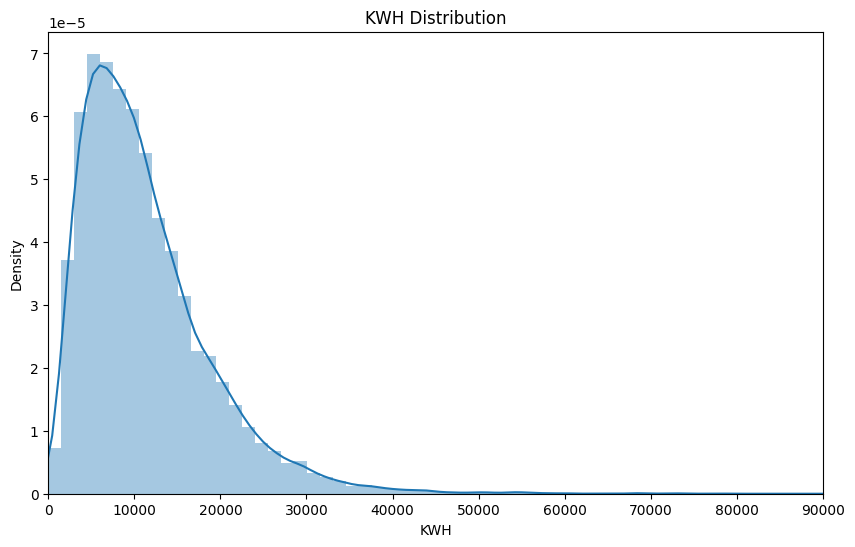

In [22]:
fig, ax = plt.subplots(figsize=[10,6])
ax.set_xlim(0,90000)
sns.distplot(df['KWH'],ax=ax, bins=100).set(title = 'KWH Distribution')

It can be seen from the graph above that the distribution of target variable is positively skewed. This means that the outliers of the distribution are further towards the right. Let's create box plot (i.e. box and whisker diagram) for our target variable to see the range of values in a more intutive way

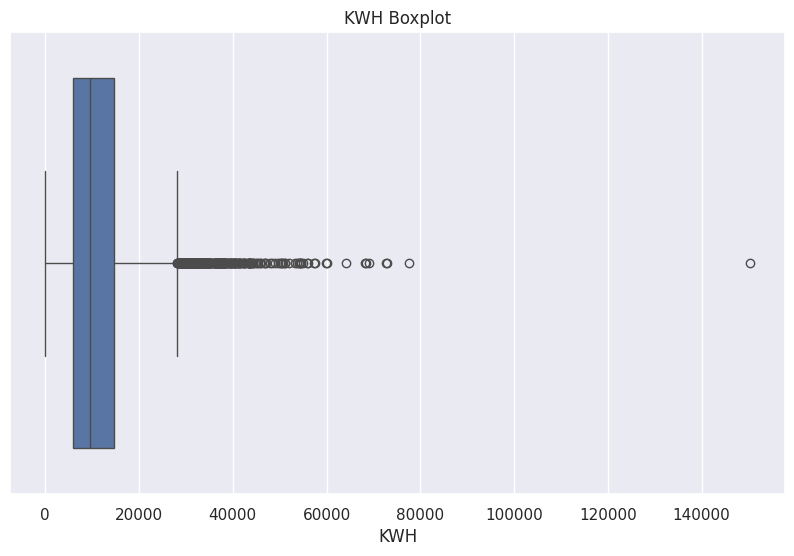

In [23]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.boxplot(x=df['KWH']).set(title = 'KWH Boxplot')

As previously observed from the distribution graph of target variable, we can clearly see in the box plot above that almost all the observations for energy consumption are under 80,000 KWH except for just one extreme outlier value above KWH 140,000. We will take care of the outlier values in the data preprocessing section

In the distribution plot above for our target variable, we observed that the distribution was right or positively skewed. Hence, to tackle issue of skewness, let's apply the log transformation on our target variable

[Text(0.5, 1.0, 'KWHlog Distribution')]

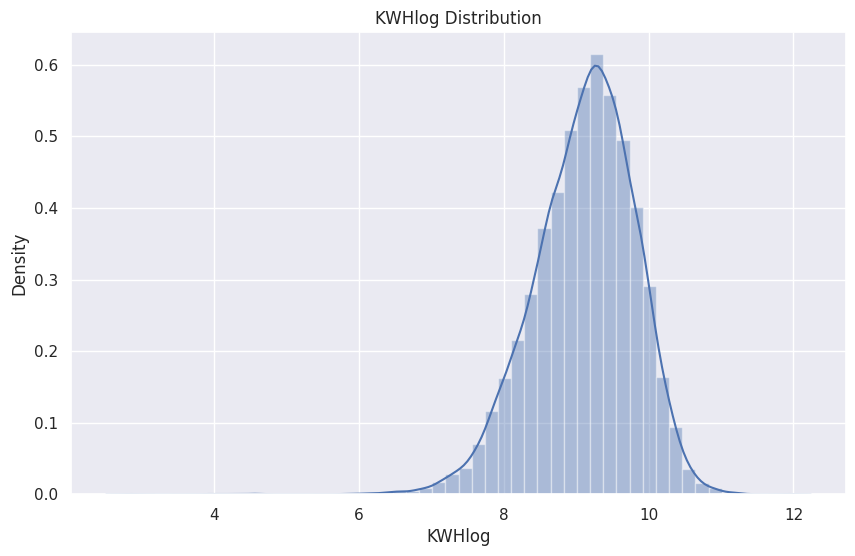

In [24]:
df['KWHlog'] = np.log(df['KWH'])
fig, ax = plt.subplots(figsize=[10,6])
sns.distplot(df['KWHlog'],ax=ax).set(title = 'KWHlog Distribution')

We can observe from the distribution graph above that log transformation has brought the distribution close to normal or bell shape curve. In other words, we can say that the log transformation reduced the skeness of our original data and hence the statistical analysis results from log transformed data will be more accurate or valid.

To extract important predictors of our target variable 'KWH', we will find correlation between target variable 'KWH' and all predictor variables and filter the predictor variables by keeping the threshold correlation value of abs(0.4), meaning the predictor variables with a correlation of abs(0.4) with target variable 'KWH' will be shown.

In [25]:
# Select only numeric columns from the DataFrame
df_numeric = df.select_dtypes(include=['number'])

# Compute the correlation matrix
corr = df_numeric.corr()

# Compute absolute correlation with the target variable 'KWH'
corr_target = abs(corr['KWH'])

# Select features with correlation > 0.4
relevant_features = corr_target[corr_target > 0.4]

# Sort features by correlation value
relevant_features = relevant_features.sort_values(ascending=False)

# Print summary
print("{} features were found to have correlation value of 0.4 or more with our target variable 'KWH'".format(len(relevant_features)))
print('----------------------------------------------------------------------------------------')
print('These features are: \n{}'.format(list(relevant_features.index)))


33 features were found to have correlation value of 0.4 or more with our target variable 'KWH'
----------------------------------------------------------------------------------------
These features are: 
['KWH', 'BTUEL', 'KWHlog', 'BTUELOTH', 'KWHOTH', 'DOLLAREL', 'DOLELOTH', 'TOTALBTUOTH', 'TOTALDOLOTH', 'BTUELCOL', 'KWHCOL', 'TOTALBTUCOL', 'TOTALBTURFG', 'KWHRFG', 'BTUELRFG', 'TOTALDOL', 'TOTALDOLCOL', 'DOLELCOL', 'KWHWTH', 'BTUELWTH', 'DOLELWTH', 'KWHSPH', 'BTUELSPH', 'TOTCSQFT', 'DOLELSPH', 'TOTROOMS', 'TOTALDOLWTH', 'ACROOMS', 'DOLELRFG', 'TOTALDOLRFG', 'NCOMBATH', 'TOTHSQFT', 'BEDROOMS']


Let's now check which are the top 20 predictors for tagret variable 'KWH' on the basis of the results of correlation analysis

In [125]:
relevant_features.sort_values(ascending = False)[:21]

,KWH
KWH,1.000000
BTUEL,1.000000
KWHlog,0.889017
BTUELOTH,0.880403
KWHOTH,0.880403
DOLLAREL,0.868712
DOLELOTH,0.702251
TOTALBTUOTH,0.676108
TOTALDOLOTH,0.655742
BTUELCOL,0.655104


Let's plot the 'KWH' correlation matrix

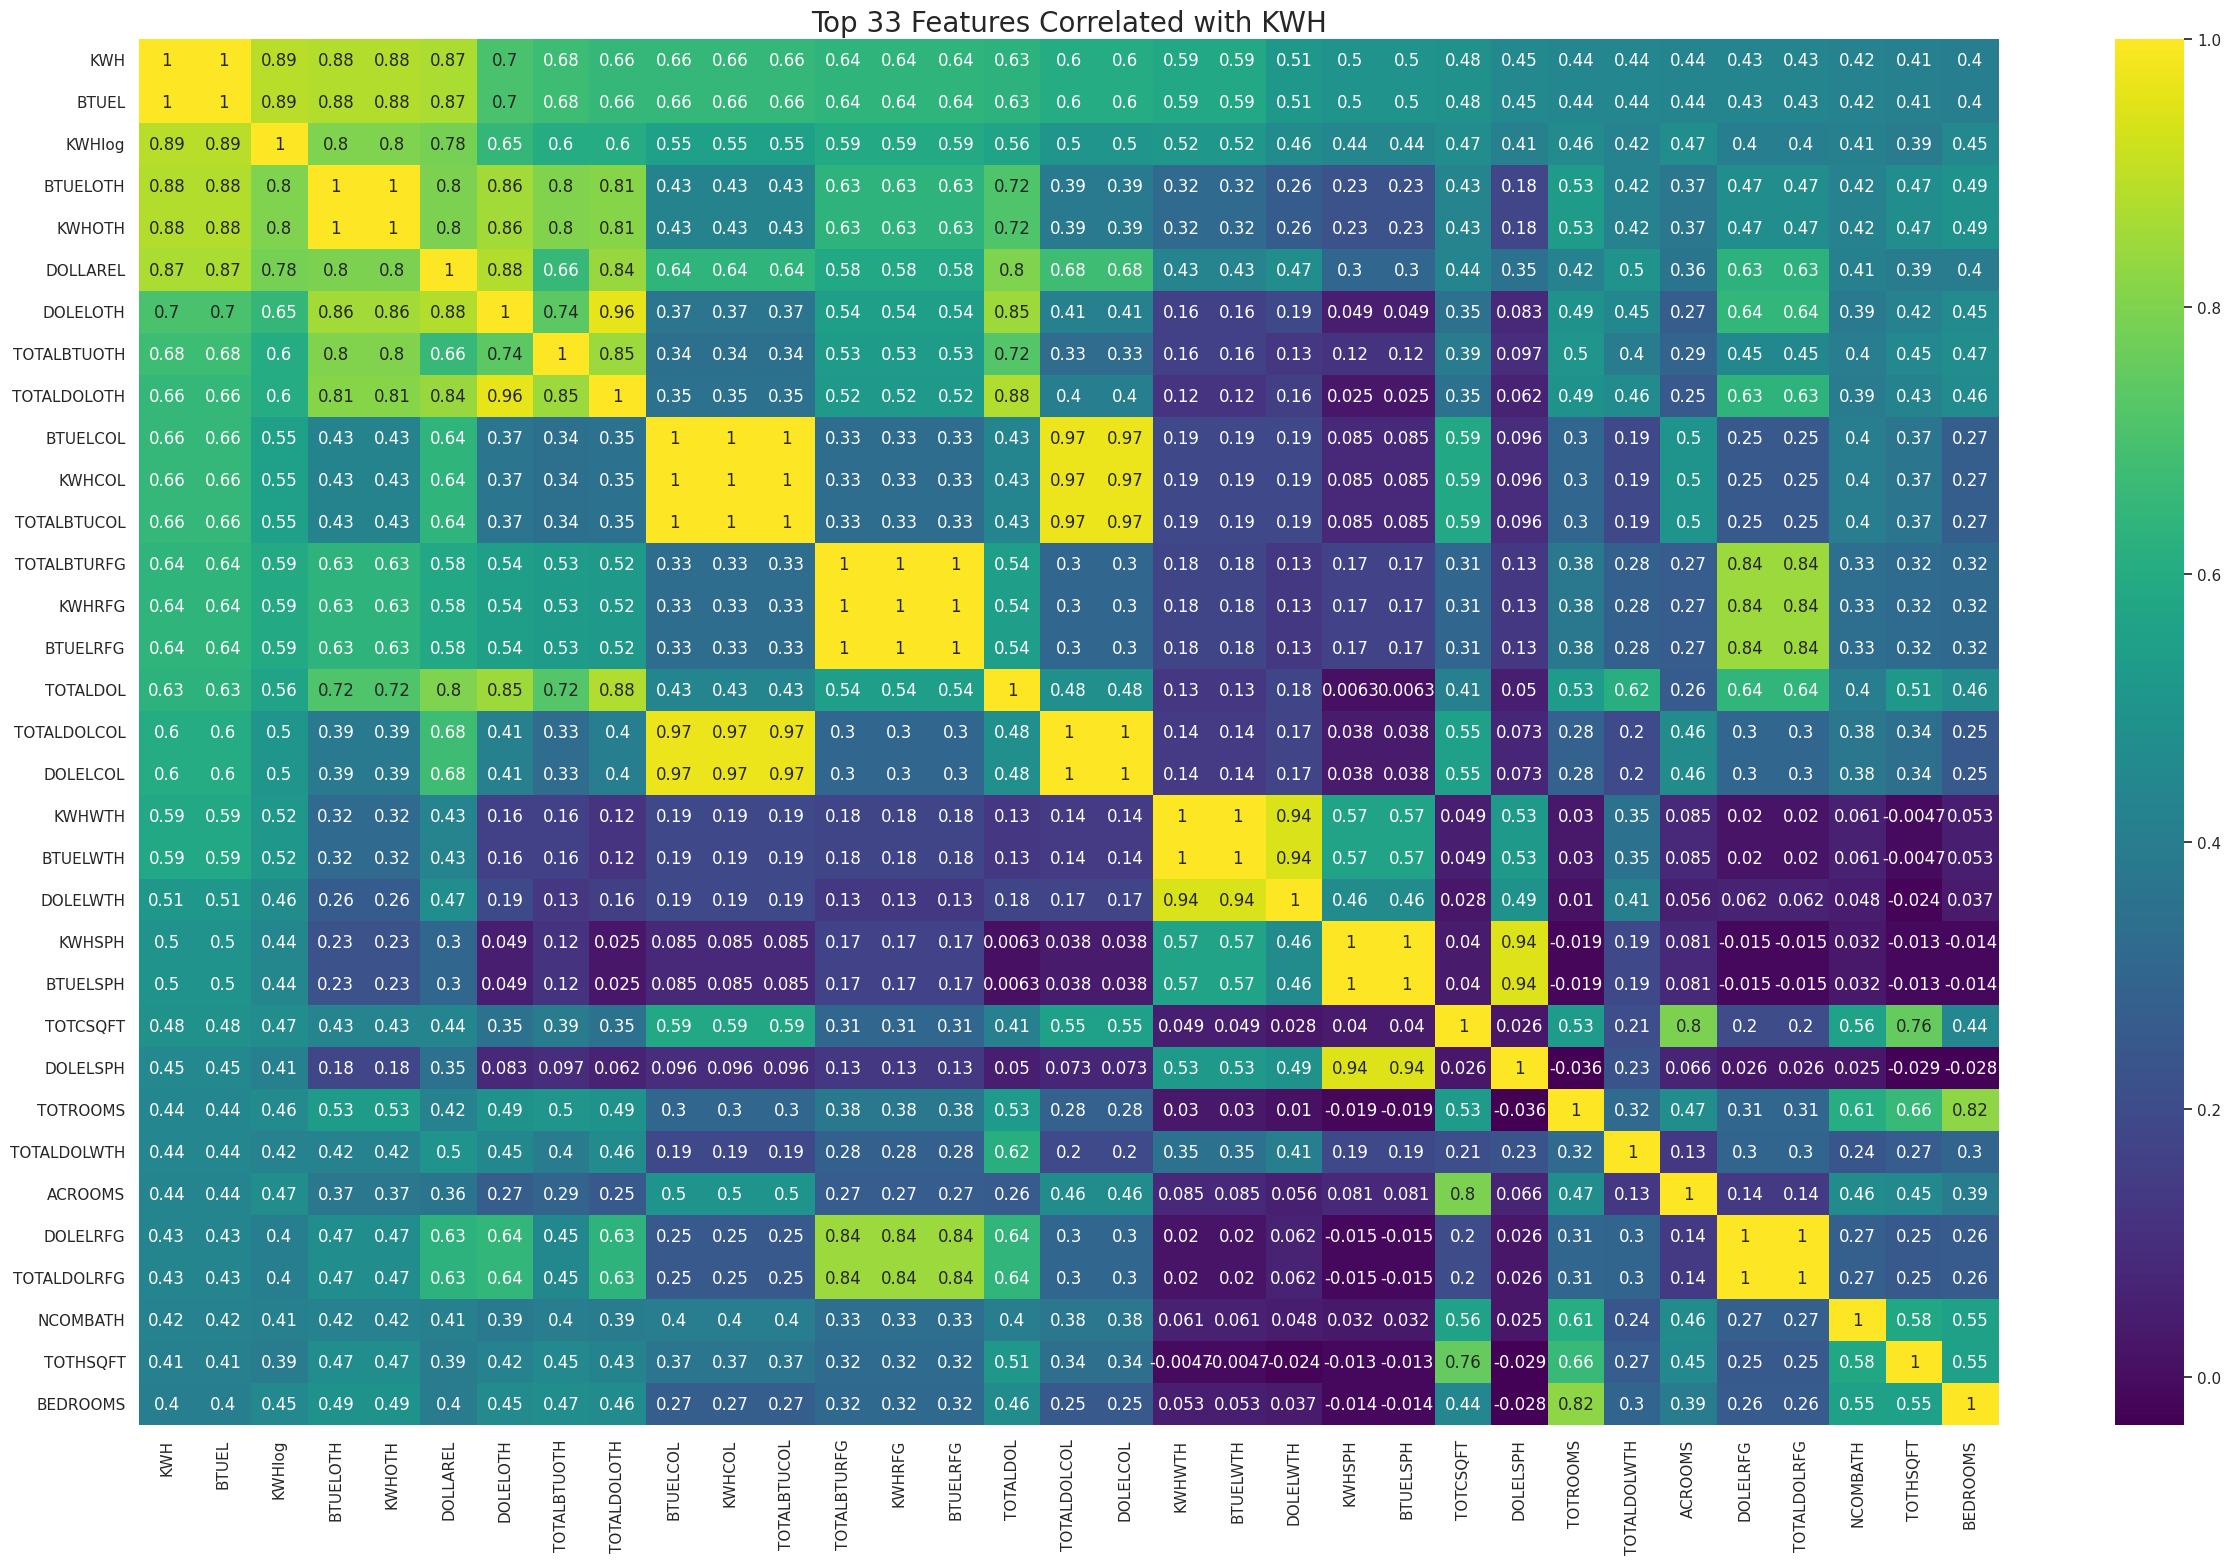

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Keep only numeric columns
df_numeric = df.select_dtypes(include=['number'])

# Step 2: Select top 33 features most correlated with 'KWH'
k = 33
cols = df_numeric.corr().nlargest(k, 'KWH')['KWH'].index

# Step 3: Compute correlation matrix for selected features
cm = df_numeric[cols].corr()

# Step 4: Plot heatmap
plt.figure(figsize=(30,18))
sns.heatmap(cm, annot=True, cmap='viridis')
plt.title(f"Top {k} Features Correlated with KWH", fontsize=20)
plt.show()


Following may be observed from the above graph:
- green and yellow color represents strong positive correlation whereas blue and purple color represents very weak positive or negative correlation
- KWH has moderate to strong positive correlation (> 0.4) with all top 32 important predictors
- Many predictor variables have high correlation with each other (such as BTUELCOL, KWHCOL, TOTALBTUCOL), thus indicating the presence of multicollinearity among predictor variables/features. We will explore collinearity among predictor features in detail in the feature selection section

Let's now explore how does these predictor variables affect the target variable 'KWH' by graphing a scatter plot between target variable and a few predictor variables

**How does 'BTUEL' i.e. Electricity Usage in BTU relates with the target variable 'KWH'?**

Text(0, 0.5, 'Electricity Usage in KWH')

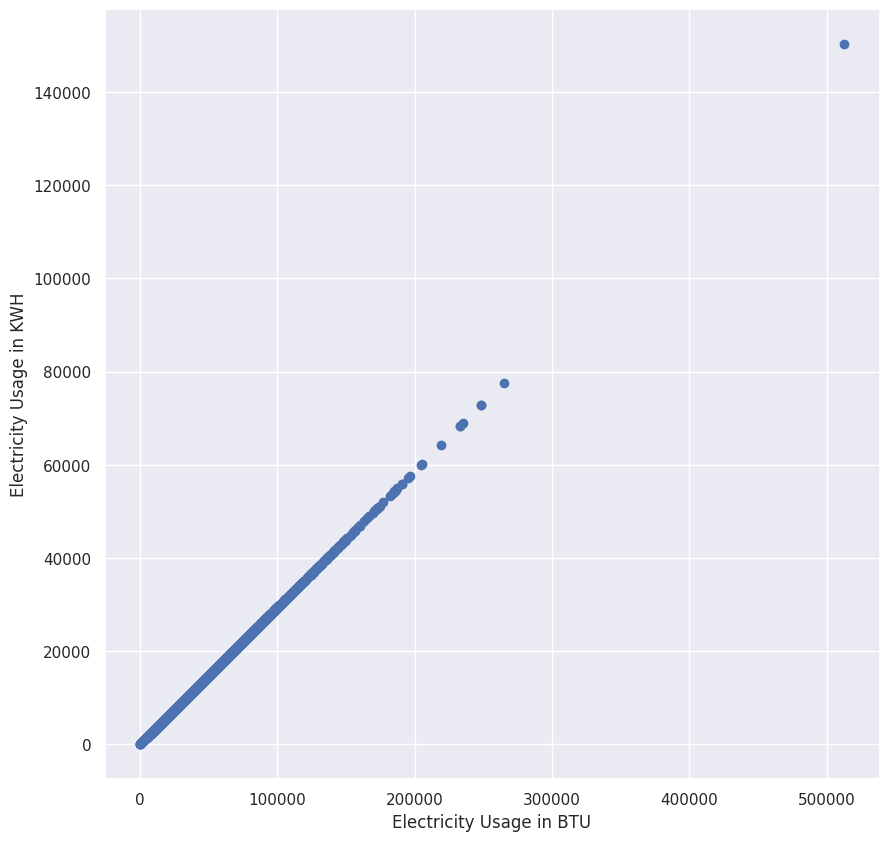

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(x='BTUEL',y='KWH',data=df)
ax.set_ylim(ymin=0)
plt.xlabel('Electricity Usage in BTU')
plt.ylabel('Electricity Usage in KWH')

We can see from the scatterplot that KWH and BTUEL is perfectly correlated. Infact, it is a duplicate variable indicating total electricity usage in different units, thousand BTU in variable BTUEL and kilowatt-hours in variable 'KWH'. Hence, in the data prepracessing section we will remove these duplicates. There are few other features in the RECS dataset which are actually either duplicates or calculated by summing up the one or more predictor features. These are as follows:

- KWH = KWHSPH + KWHCOL + KWHWTH + KWHRFG + KWHOTH<br>
- BTUEL = BTUELSPH + BTUELCOL + BTUELWTH + BTUELRFG + BTUELOTH<br>
- DOLLAREL = DOLELSPH + DOLELCOL + DOLELWTH + DOLELRFG + DOLELOTH<br>
- CUFEETNG = CUFEETNGSPH + CUFEETNGWTH + CUFEETNGOTH<br>
- BTUNG = BTUNGSPH + BTUNGWTH + BTUNGOTH<br>
- DOLLARNG = DOLNGSPH + DOLNGWTH + DOLNGOTH<br>
- GALLONLP = GALLONLPSPH + GALLONLPWTH + GALLONLPOTH<br>
- BTULP = BTULPSPH + BTULPWTH + BTULPOTH<br>
- DOLLARLP = DOLLPSPH	+ DOLLPWTH + DOLLPOTH<br>
- GALLONFO = GALLONFOSPH + GALLONFOWTH + GALLONFOOTH<br>
- BTUFO = BTUFOSPH + BTUFOWTH + BTUFOOTH<br>
- DOLLARFO = DOLFOSPH + DOLFOWTH + DOLFOOTH<br>
- GALLONKER = GALLONKERSPH + GALLONKERWTH + GALLONKEROTH<br>
- BTUKER = BTUKERSPH + BTUKERWTH + BTUKEROTH<br>
- DOLLARKER = DOLKERSPH + DOLKERWTH + DOLKEROTH<br>
- TOTALBTU = TOTALBTUSPH + TOTALBTUCOL + TOTALBTUWTH + TOTALBTURFG + TOTALBTUOTH<br>
- TOTALDOL = TOTALDOLSPH + TOTALDOLCOL + TOTALDOLWTH + TOTALDOLRFG + TOTALDOLOTH<br>
- TOTALBTUSPH = BTUELSPH + BTUNGSPH + BTULPSPH + BTUFOSPH + BTUKERSPH<br>
- TOTALBTUCOL = BTUELCOL<br>
- TOTALBTUWTH = BTUELWTH + BTUNGWTH + BTULPWTH +  + BTUFOWTH + BTUKERWTH<br>
- TOTALBTURFG = BTUELRFG<br>
- TOTALBTUOTH = BTUELOTH + BTUNGOTH + BTULPOTH + BTUFOOTH + BTUKEROTH<br>
- TOTALDOLSPH = DOLELSPH + DOLNGSPH + DOLLPSPH + DOLFOSPH + DOLKERSPH<br>
- TOTALDOLCOL = DOLELCOL<br>
- TOTALDOLWTH = DOLELWTH + DOLNGWTH + DOLLPWTH + DOLFOWTH + DOLKERWTH<br>
- TOTALDOLRFG = DOLELRFG<br>
- TOTALDOLOTH = DOLELOTH + DOLNGOTH + DOLLPOTH + DOLFOOTH + DOLKEROTH<br>

We will talk about these in detail in data preprocessing section


**Now, let's check how does Total Cooled Square Footage (TOTCSQFT), Total heated square footage (TOTHSQFT) and Total Number of Rooms in Housing (TOTROOMS) relates with the target variable 'KWH'?**

Text(0, 0.5, 'Electricity Usage in KWH')

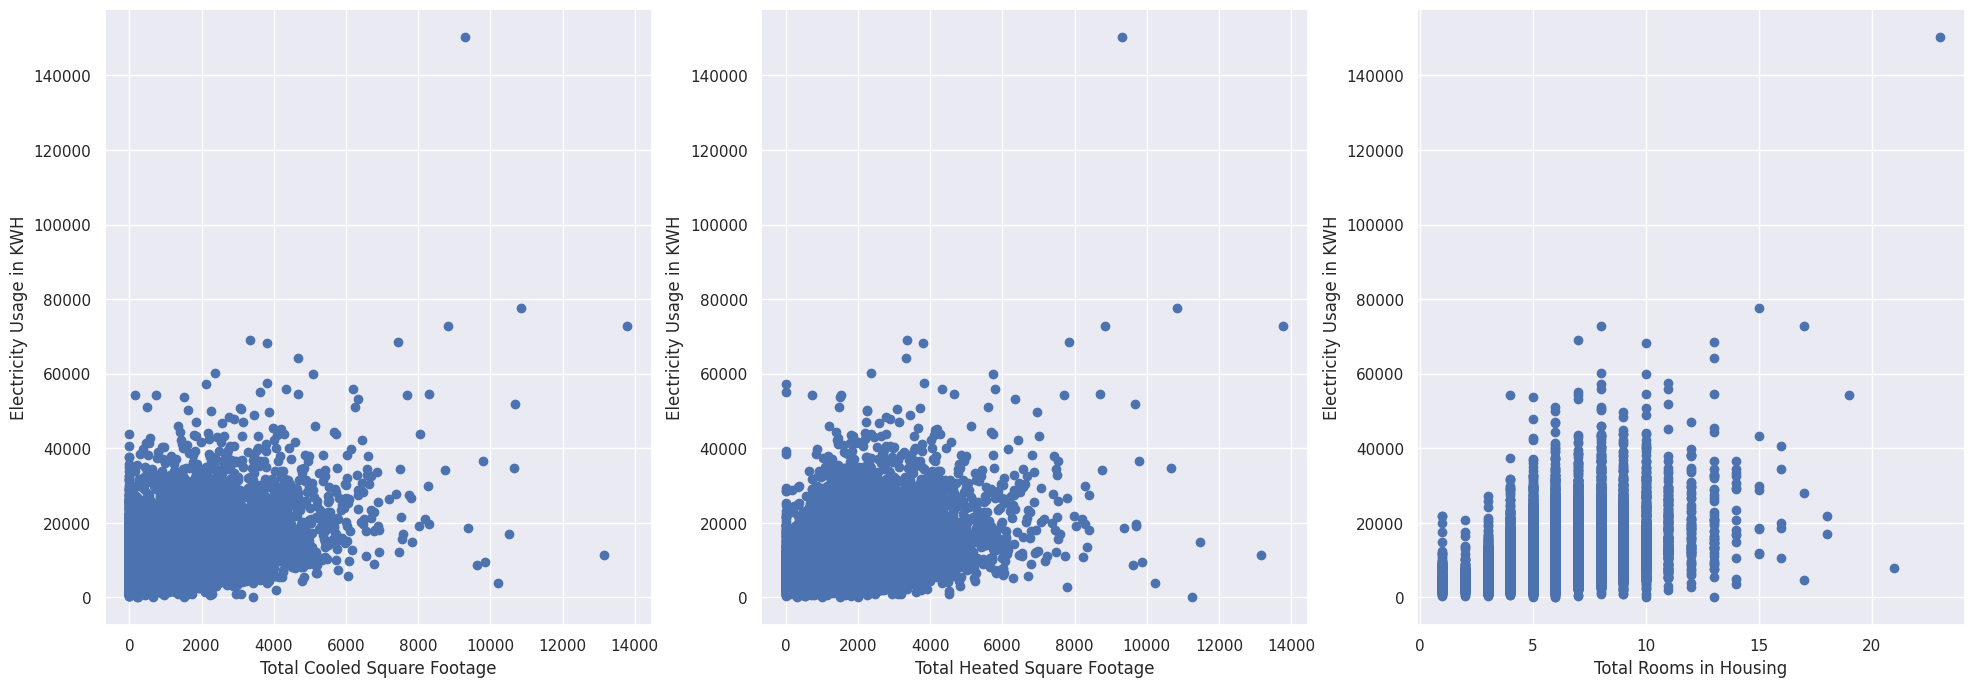

In [29]:
#f = plt.figure(figsize = (10,3))
fig, axs = plt.subplots(1, 3, figsize=(24, 8))
axs[0].scatter(x='TOTCSQFT',y='KWH',data=df)
axs[1].scatter(x='TOTHSQFT',y='KWH',data=df)
axs[2].scatter(x='TOTROOMS',y='KWH',data=df)
axs[0].set_xlabel('Total Cooled Square Footage')
axs[0].set_ylabel('Electricity Usage in KWH')
axs[1].set_xlabel('Total Heated Square Footage')
axs[1].set_ylabel('Electricity Usage in KWH')
axs[2].set_xlabel('Total Rooms in Housing')
axs[2].set_ylabel('Electricity Usage in KWH')

We previosuly found that total cooled square footage, total heated square footage and total rooms in housing had a moderate positive correlation with target variable 'KWH'. The scatter plots above are quite informative and are in-line with the results from correlation analysis. We can see that we do not have one fixed linear relationship across the entire domain of values of total cooled square footage, total heated square footage and total rooms in housing.

<a id="46"></a>
#### f. Detect Outliers and Anomalies

Previously, in the summary statistics section, we found that the mean value was different from the median value for the features HDD65, CDD65, HDD30YR, CDD30YR, TOTSQFT, KWH, CDD80, OA_LAT. In addition, we found a large difference in the 75th percentile and maximum value for these features. These observations indicates the presence of potential outlier values in these features. Let's check each of these feature for outliers using box plot (i.e. box and whisker diagram)

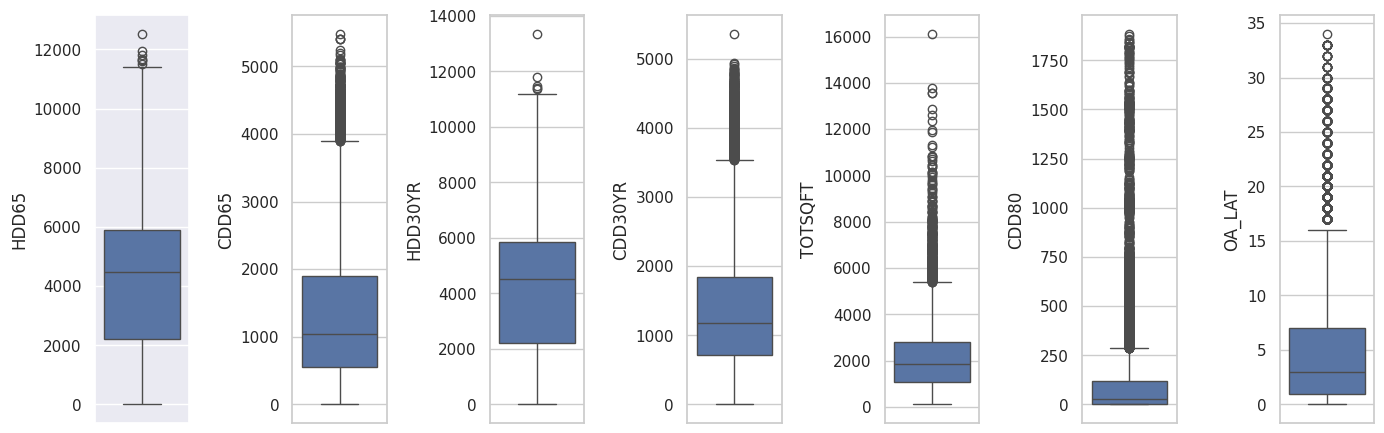

In [30]:
outl_cols = ['HDD65', 'CDD65', 'HDD30YR', 'CDD30YR', 'TOTSQFT', 'CDD80', 'OA_LAT']
number_of_columns=len(outl_cols)
number_of_rows = len(outl_cols)-1/number_of_columns
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(outl_cols)):
    plt.subplot(round(number_of_rows + 1),number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(y = df[outl_cols[i]],orient='h')
    plt.tight_layout()

We can see from the box plot above that almost all the features shows outliers present in the dataset. Let's now check the linearity of the variables by plotting distribution graph and look for skewness of features using Kernel density estimate (kde)

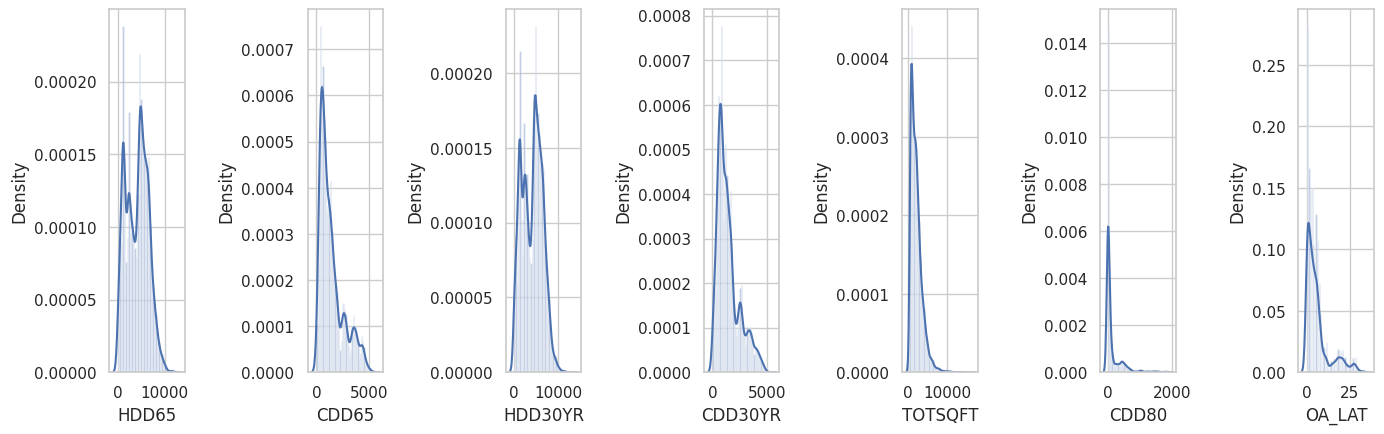

In [31]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(outl_cols)):
    plt.subplot(round(number_of_rows + 1),number_of_columns,i+1)
    sns.distplot(df[outl_cols[i]],kde=True)
    plt.tight_layout()

All the predictor variables depicted in kde graph above are right skewed/positively skewed

In the [Check for Missing Values](#d-check-for-missing-values) section, we found 72 predictor features that had NA i.e. 'Not Applicable' values in more than 95% of the observations. Let's now check whther these 72 features correlate with the target variable 'KWH' or not

In [32]:
target_var = 'KWH'
feature_target_corr = {}
for col in list(na_col_names.values):
    feature_target_corr[col + '-' + target_var] = round(scipy.stats.spearmanr(df[col], df[target_var])[0],2)
print("Predictor Feature vs Target Variable Correlations")
print(feature_target_corr)

Predictor Feature vs Target Variable Correlations
{'ORIG1FAM-KWH': np.float64(-0.1), 'LOOKLIKE-KWH': np.float64(-0.08), 'TYPEHUQ4-KWH': np.float64(0.06), 'PCTBSTCL-KWH': np.float64(0.08), 'FINATTRMS-KWH': np.float64(0.03), 'ATTCHT2-KWH': np.float64(0.02), 'PCTATTHT-KWH': np.float64(0.01), 'ATTCCL2-KWH': np.float64(0.04), 'PCTATTCL-KWH': np.float64(0.03), 'STGRILA-KWH': np.float64(0.03), 'HELPFRIY-KWH': np.float64(-0.01), 'TYPERFR3-KWH': np.float64(0.13), 'SIZRFRI3-KWH': np.float64(0.13), 'REFRIGT3-KWH': np.float64(0.13), 'MONRFRI3-KWH': np.float64(0.13), 'AGERFRI3-KWH': np.float64(0.13), 'ESFRIG3-KWH': np.float64(0.08), 'HELPFRZY-KWH': np.float64(-0.0), 'UPRTFRZR2-KWH': np.float64(0.11), 'SIZFREEZ2-KWH': np.float64(0.11), 'FREEZER2-KWH': np.float64(0.11), 'AGEFRZR2-KWH': np.float64(0.11), 'HELPDWY-KWH': np.float64(0.03), 'HELPCWY-KWH': np.float64(0.01), 'PCSLEEP3-KWH': np.float64(0.11), 'DNTHEAT-KWH': np.float64(-0.11), 'EQUIPNOHEAT-KWH': np.float64(-0.09), 'FUELNOHEAT-KWH': np.float64

Spearman correlation coefficient values between target variable 'KWH' and 72 predictor features reveal low to negligible correlation. We could have employed imputation technique to address these 72 features, however, we can drop them due to high missing values i.e. 'Not Applicable' values and evidence of negligible correlation suggesting that the set of these features have negligible amount of predictive power over the outcome variable. Hence, these features will be removed in data preprocessing section

<a id="47"></a>
#### g. Explore Additional Predictor Variables

Let's now explore the relationship between target variable 'KWH' and categorical features 'METROMICRO', 'UR' and 'IECC_Climate_Pub' using box plots

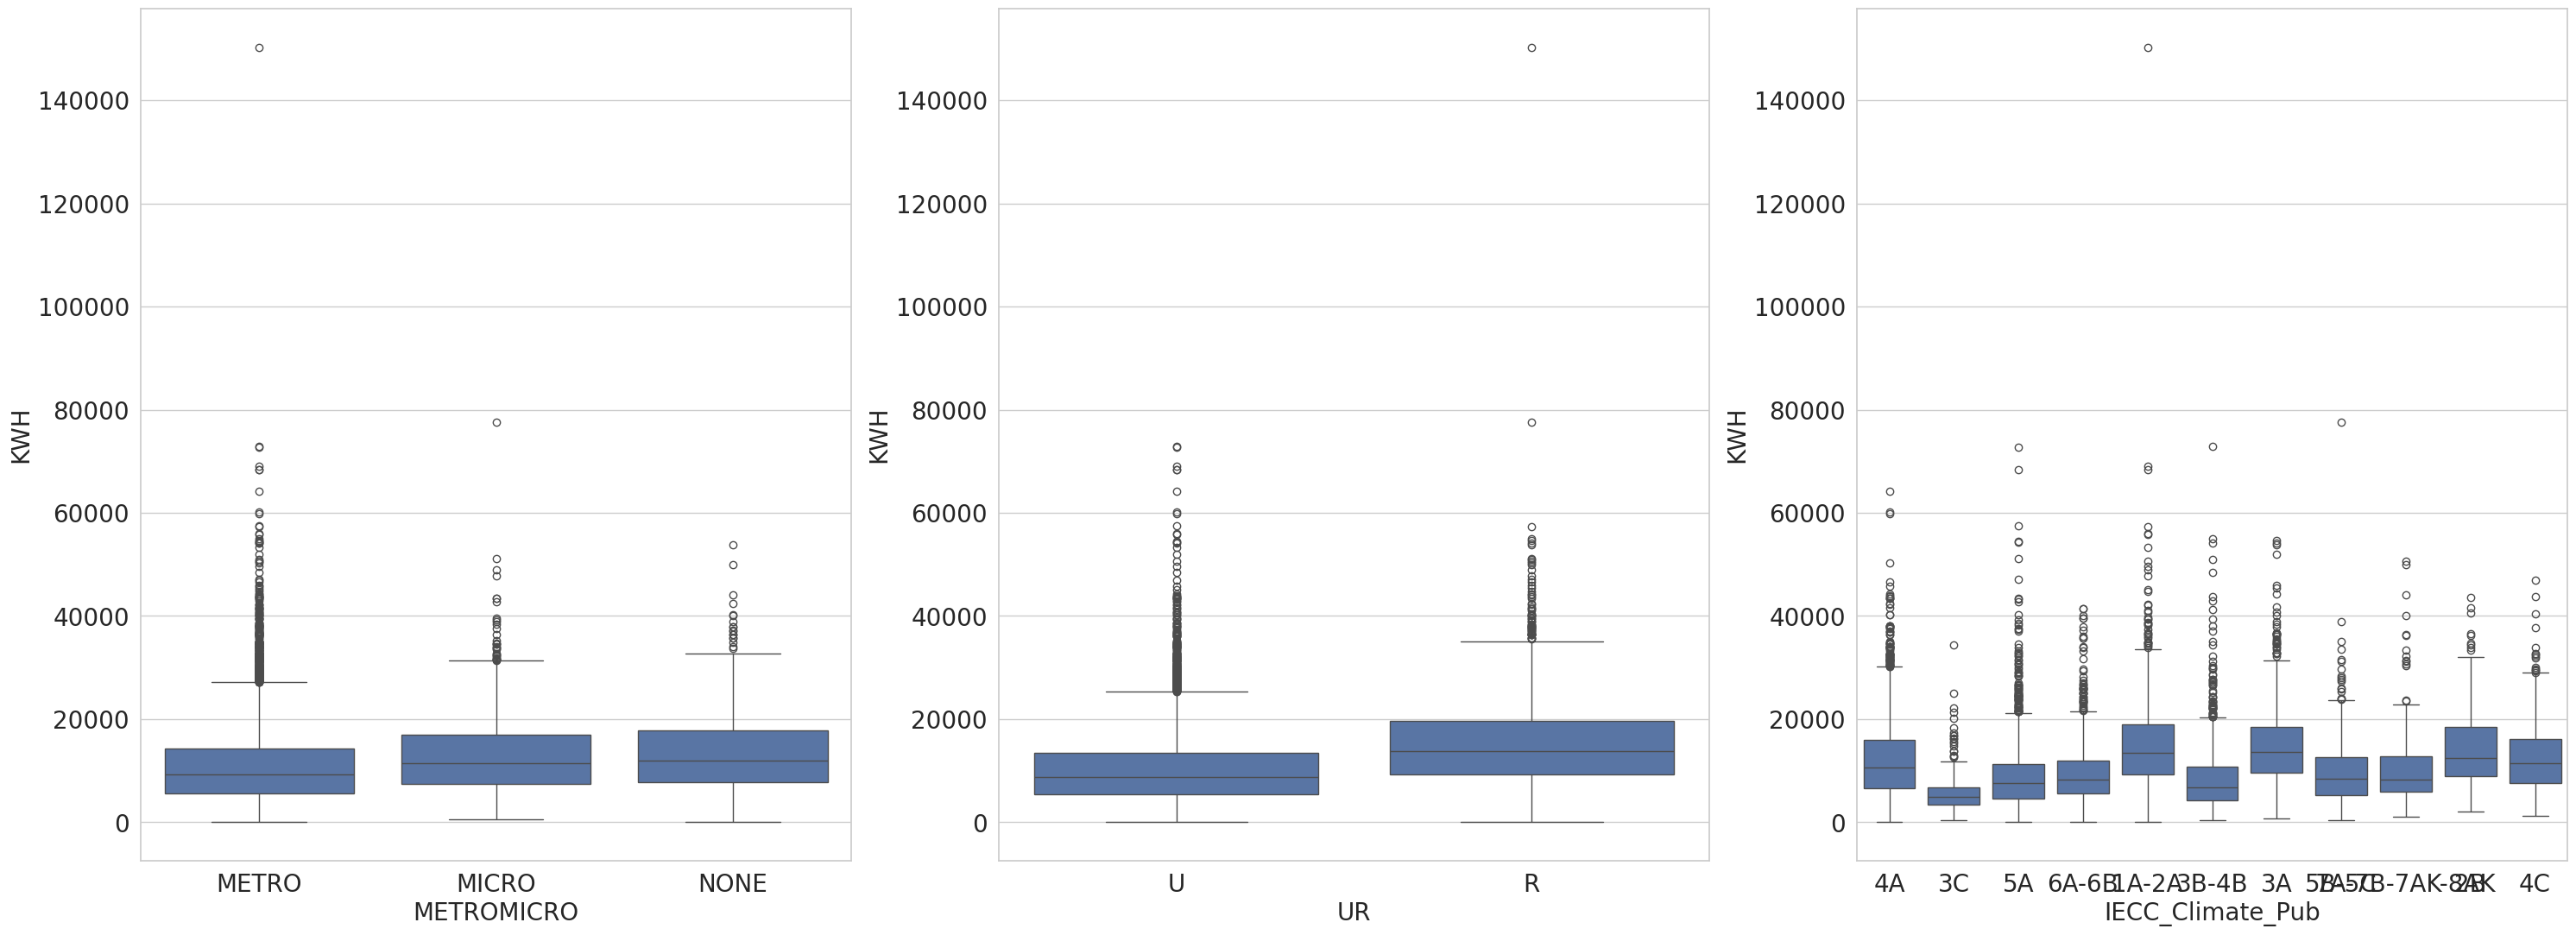

In [33]:
number_of_columns=len(cat_features_remaining)
number_of_rows = len(cat_features_remaining)-1/number_of_columns
plt.figure(figsize=(10*number_of_columns, 16*number_of_rows))
for i in range(0,len(cat_features_remaining)):
    plt.subplot(round(number_of_rows + 1),number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(x = df[cat_features_remaining[i]], y ='KWH', data = df)
    plt.xlabel(cat_features_remaining[i], size = 20)
    plt.ylabel('KWH', size = 20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.tight_layout()

We can observe in the box plots above that all the categories of categorical features has energy consumption value under KWH 80,000 except for just one extreme outlier value above KWH 140,000. We will take care of the outlier values in the data preprocessing section

We will convert the categorical labels of categorical features into numbers using the `OneHotEncoder` inside `ColumnTransformer` later in the model building section. It is to be noted that incase the cardinality of a particular categorical feature is very high, then using one-hot encoding is not recommended as it might lead to a curse of dimensionality. However, in our dataset we have three categorical features with feature 'IECC_Climate_Pub' having the maximum unique feature values of 11

Let's now explore how some of the housing characterstics, usage patterns and household demographics features are related with the target variable 'KWH' i.e. Total Electricity usage in KWH. The following features under housing characterstics, usage patterns and household demographics will be explored in-depth to uncover underlying patterns in the dataset:
- **Housing Characterstics:** type of housing unit (TYPEHUQ), year housing unit was built (YEARMADERANGE), total number of rooms in housing (TOTROOMS)
- **Usage Patterns:** frequency of clothes dryer use (DRYRUSE), frequency of oven use (OVENUSE), frequency of dishwasher use (DWASHUSE)
- **Household Demographics :** number of household members (NHSLDMEM), gross household income (MONEYPY)

It may be noted here that all the features falling under housing characterstics, usage patters and household demographics are discrete numerical variables i.e. the variables whose values exist in a particular range or are countable in a finite amount of time

**How does Housing Characterstics features relates with the target variable 'KWH'?**

a) Relation Between Type of Housing Unit and Energy Consumption in KWH

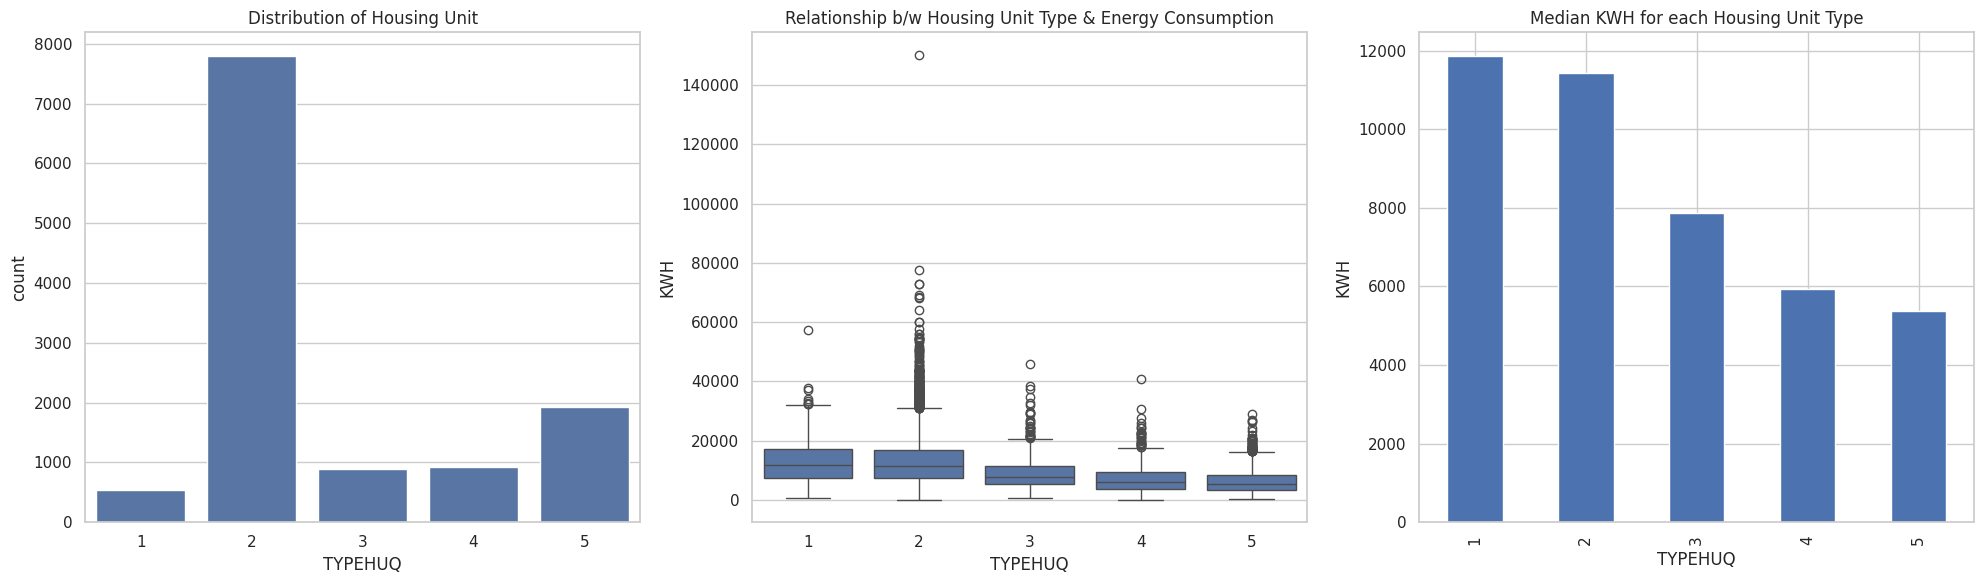

In [34]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Plot
plt.figure(figsize=(20,6))

# 1. Countplot
plt.subplot(1,3,1)
sns.set_style('whitegrid')
ax0 = sns.countplot(x='TYPEHUQ', data=df)
ax0.set_title('Distribution of Housing Unit')

# 2. Boxplot
plt.subplot(1,3,2)
ax1 = sns.boxplot(x='TYPEHUQ', y='KWH', data=df)
ax1.set_title('Relationship b/w Housing Unit Type & Energy Consumption')

# 3. Barplot (Median)
plt.subplot(1,3,3)
df.groupby('TYPEHUQ')['KWH'].median().plot.bar()
plt.title('Median KWH for each Housing Unit Type')
plt.ylabel('KWH')

plt.tight_layout()
plt.show()


Based on the above plots, we can observe the following:
- Housing unit type 2 i.e. Single-Family Detached dominates the data distribution of Housing Unit type (n = ~7800 observations)
- We may observe a clear pattern in the boxplot above that as housing unit type change from Mobile home to single-family home to apartment in building, lesser the energy is consumed
- From the plot 'Median KWH for each Housing Unit type', we can see that feature TYPEHUQ has a direct relation with the target variable

b) Relation Between Year in which Housing Unit was built and Energy Consumption in KWH

Text(0, 0.5, 'KWH')

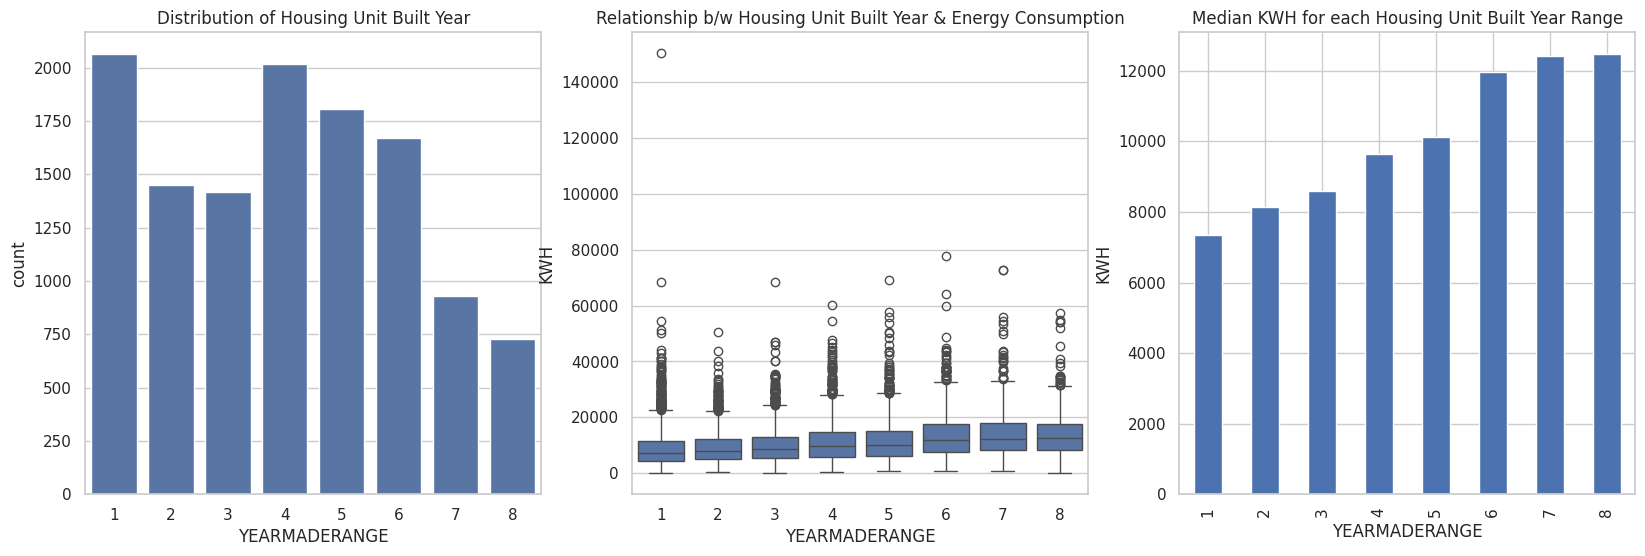

In [35]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.set_style('whitegrid')
ax0 = sns.countplot(x='YEARMADERANGE', data = df)
ax0.set_title('Distribution of Housing Unit Built Year')
plt.subplot(1,3,2)
ax1 = sns.boxplot(x='YEARMADERANGE', y ='KWH', data = df)
ax1.set_title('Relationship b/w Housing Unit Built Year & Energy Consumption')
plt.subplot(1,3,3)
df.groupby('YEARMADERANGE')['KWH'].median().plot.bar()
plt.title('Median KWH for each Housing Unit Built Year Range')
plt.ylabel('KWH')

Based on the above plots, we can observe the following:
- We can see from the barplot that Housing Unit Built Year has data well-distributed across different levels/range of built year
- We may see a clear pattern in the boxplot above that most recently the housing unit was built, more energy consumption can be observed
- 'Median KWH for each housing unit built year range' graph observation is in-line with boxplot results indicating that feature YEARMADERANGE indeed has a direct relation with the target variable

c) Relation Between Total Rooms in  Housing and Energy Consumption in KWH

Text(0, 0.5, 'KWH')

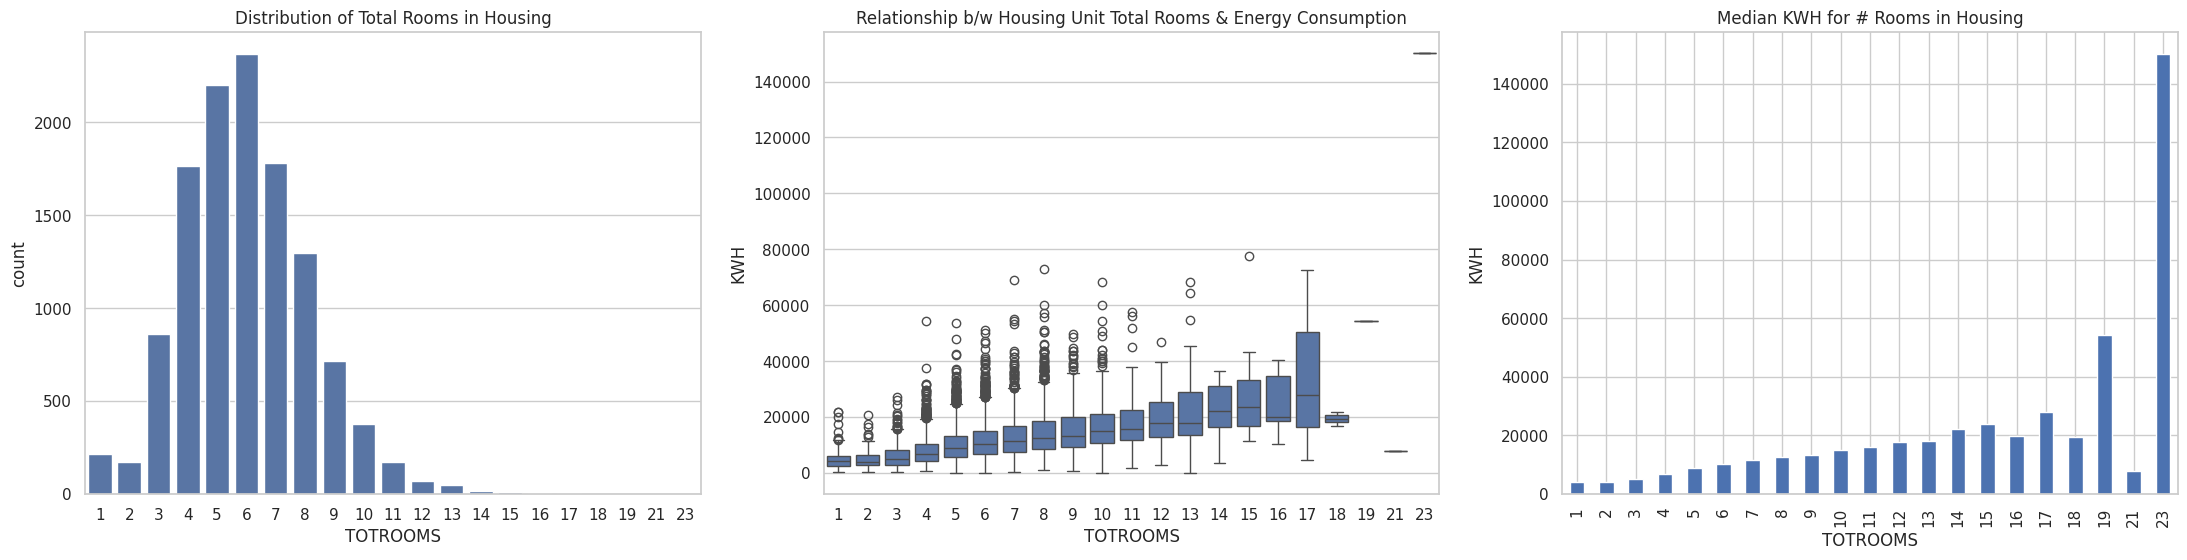

In [36]:
plt.figure(figsize=(27,6))
plt.subplot(1,3,1)
sns.set_style('whitegrid')
ax0 = sns.countplot(x='TOTROOMS', data = df)
ax0.set_title('Distribution of Total Rooms in Housing')
plt.subplot(1,3,2)
ax1 = sns.boxplot(x='TOTROOMS', y ='KWH', data = df)
ax1.set_title('Relationship b/w Housing Unit Total Rooms & Energy Consumption')
plt.subplot(1,3,3)
df.groupby('TOTROOMS')['KWH'].median().plot.bar()
plt.title('Median KWH for # Rooms in Housing')
plt.ylabel('KWH')

Based on the above plots, we can observe the following:
- Most of the Housing units typically have less than 12 rooms in total. Only few of the housings have more than or equal to 12 rooms in total. Hence, we could combine these levels together and create a new one 'more than 11 rooms'. We will take care of this in data preprocessing section
- We may see a clear pattern in the boxplot above that more the number of rooms in the housing, more the energy consumption is
- Similarly, the median KWH plot also show that as number of rooms in housing increases, the energy consumption increases as well, indicating that feature TOTROOMS has a direct relation with the target variable

**How does Appliance Usage Pattern features relates with the target variable 'KWH'?**

a) Relation Between Frequency of Clothes Dryer Use and Energy Consumption in KWH

Text(0, 0.5, 'KWH')

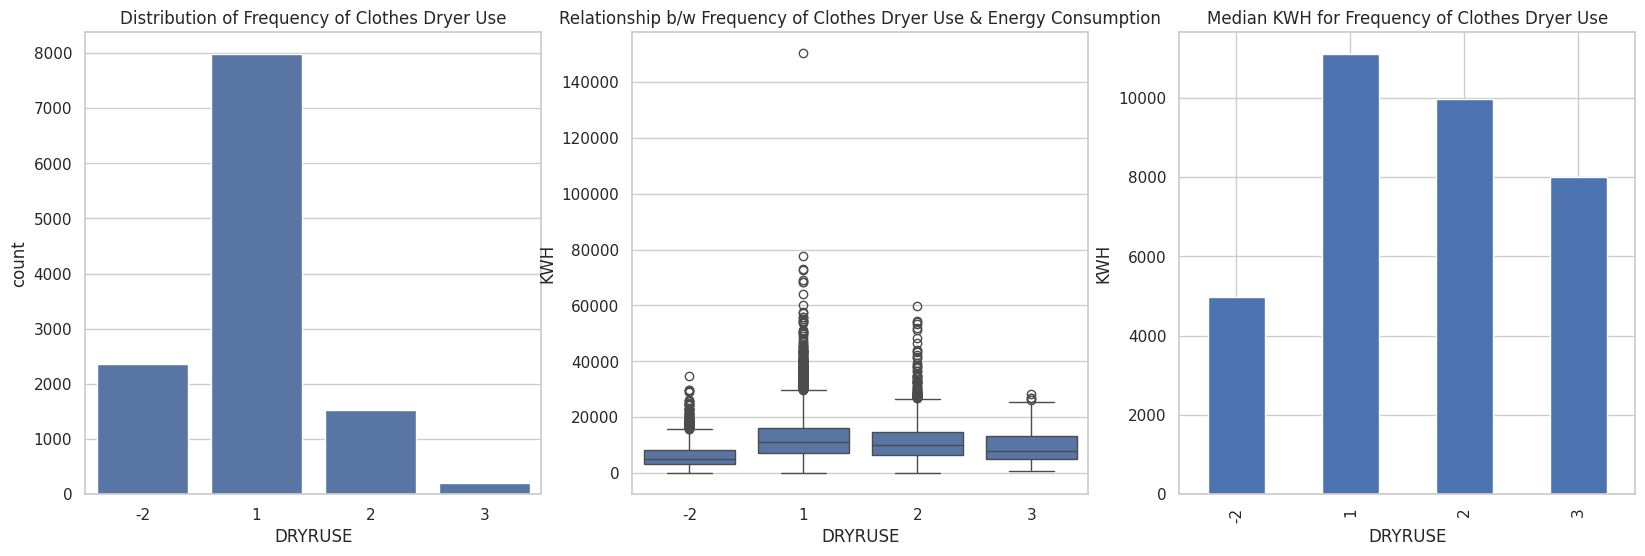

In [37]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.set_style('whitegrid')
ax0 = sns.countplot(x='DRYRUSE', data = df)
ax0.set_title('Distribution of Frequency of Clothes Dryer Use')
plt.subplot(1,3,2)
ax1 = sns.boxplot(x='DRYRUSE', y ='KWH', data = df)
ax1.set_title('Relationship b/w Frequency of Clothes Dryer Use & Energy Consumption')
plt.subplot(1,3,3)
df.groupby('DRYRUSE')['KWH'].median().plot.bar()
plt.title('Median KWH for Frequency of Clothes Dryer Use')
plt.ylabel('KWH')

Based on the above plots, we can observe the following:
- Most of the households use clothes dryer everytime they wash clothes (depicted by factor/level value 1. Note that factor/level value 3 indicates infrequent use of clothes dryer)
- We can observe a clear pattern in the boxplot above that more frequently a household use clothes dryer, more is the energy consumption
- The median KWH plot results are in-line with boxplot results, indicating that more frequently household use clothes dryer, more is the median value of energy consumption. Thus, feature DRYRUSE has a direct relation with the target variable

b) Relation Between Frequency of Oven Use and Energy Consumption in KWH

Text(0, 0.5, 'KWH')

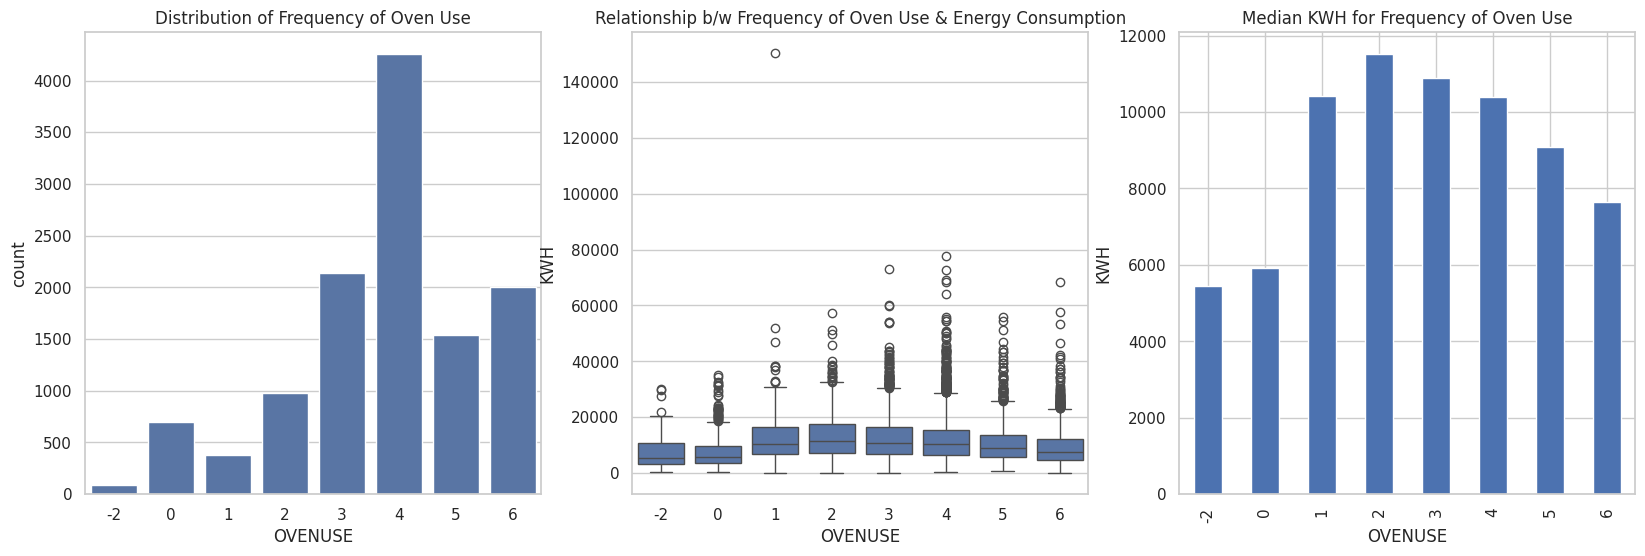

In [38]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.set_style('whitegrid')
ax0 = sns.countplot(x='OVENUSE', data = df)
ax0.set_title('Distribution of Frequency of Oven Use')
plt.subplot(1,3,2)
ax1 = sns.boxplot(x='OVENUSE', y ='KWH', data = df)
ax1.set_title('Relationship b/w Frequency of Oven Use & Energy Consumption')
plt.subplot(1,3,3)
df.groupby('OVENUSE')['KWH'].median().plot.bar()
plt.title('Median KWH for Frequency of Oven Use')
plt.ylabel('KWH')

Based on the above plots, we can observe the following:
- Majority of the households use the oven 'few times a week' (depicted by factor/level value 1. Note that factor/level value 1 indicates use of oven three or four times a day)
- Contrary to the results of barplot, from the boxplot and median KWH plot, we can observe that most energy consumption was from the households who were using oven 'two times a day' (depicted by higher median value for factor/level value 2 of feature OVENUSE)

c) Relation Between Frequency of Dishwasher Use and Energy Consumption in KWH

Text(0, 0.5, 'KWH')

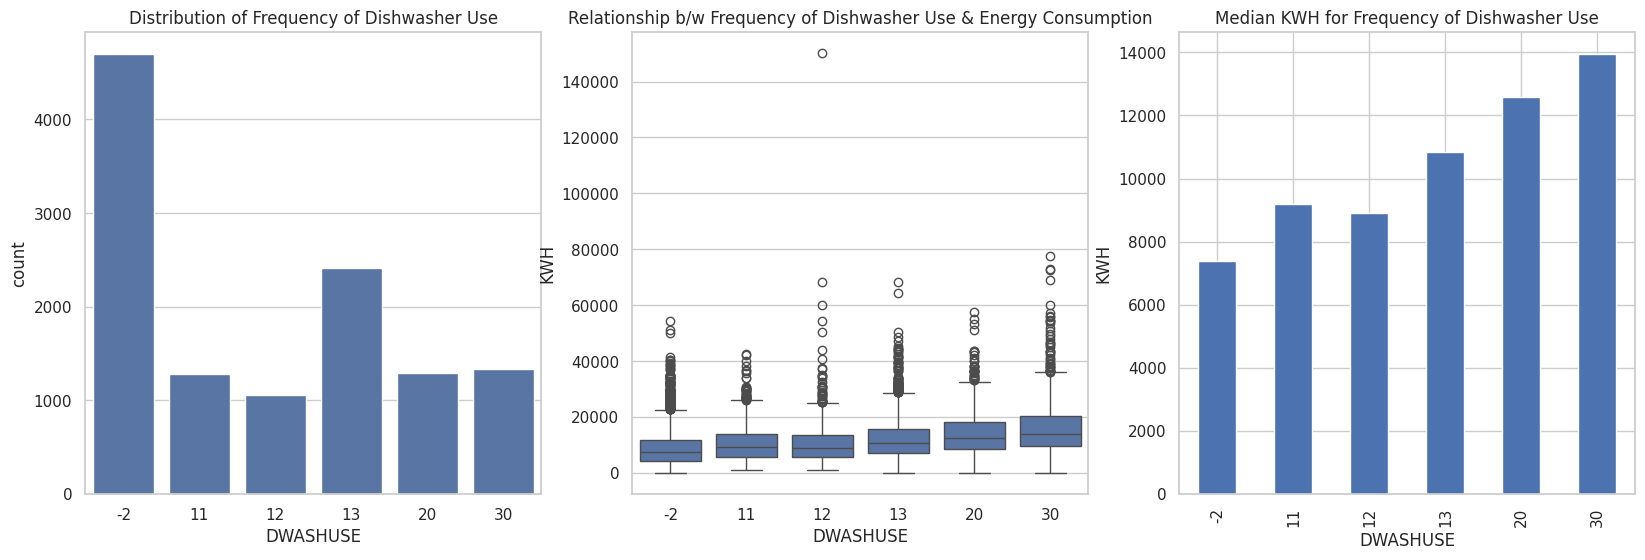

In [39]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.set_style('whitegrid')
ax0 = sns.countplot(x='DWASHUSE', data = df)
ax0.set_title('Distribution of Frequency of Dishwasher Use')
plt.subplot(1,3,2)
ax1 = sns.boxplot(x='DWASHUSE', y ='KWH', data = df)
ax1.set_title('Relationship b/w Frequency of Dishwasher Use & Energy Consumption')
plt.subplot(1,3,3)
df.groupby('DWASHUSE')['KWH'].median().plot.bar()
plt.title('Median KWH for Frequency of Dishwasher Use')
plt.ylabel('KWH')

Based on the above plots, we can observe the following:
- From the barplot, we may observe that most of the households use their dishwashers '2 or 3 times a week' (depicted by factor/level value 13. Note that factor/level value 11 indicates use of dishwasher less than once a week and factor/level 30 indicates using dishwasher at least once each day)
- We can observe a clear pattern in the boxplot as well as median KWH plot above that more frequently household use dishwasher, more is the energy consumption. Thus, feature DWASHUSE has a direct relation with the target variable

**How does Household Demographic features relates with the target variable 'KWH'?**

a) Relation Between Total Members in Household and Energy Consumption in KWH

Text(0, 0.5, 'KWH')

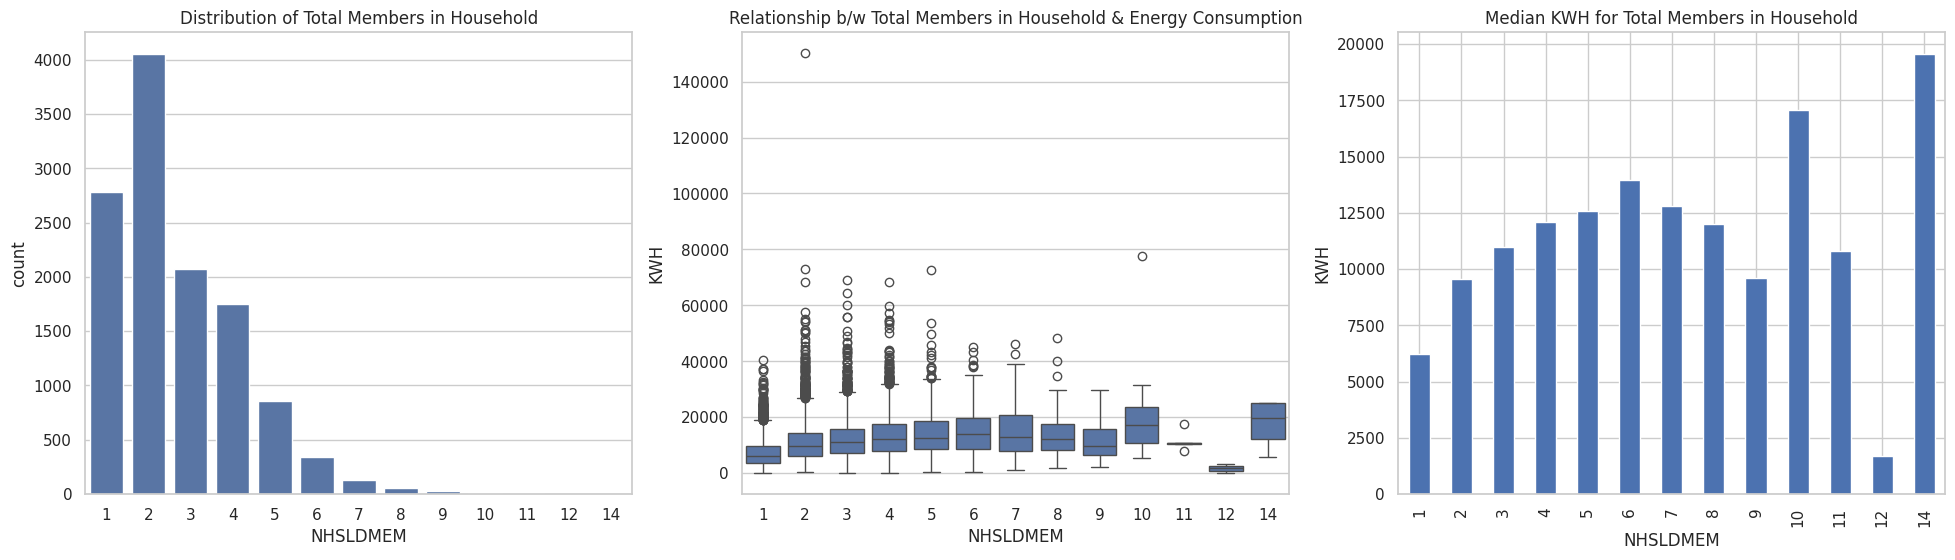

In [40]:
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
sns.set_style('whitegrid')
ax0 = sns.countplot(x='NHSLDMEM', data = df)
ax0.set_title('Distribution of Total Members in Household')
plt.subplot(1,3,2)
ax1 = sns.boxplot(x='NHSLDMEM', y ='KWH', data = df)
ax1.set_title('Relationship b/w Total Members in Household & Energy Consumption')
plt.subplot(1,3,3)
df.groupby('NHSLDMEM')['KWH'].median().plot.bar()
plt.title('Median KWH for Total Members in Household')
plt.ylabel('KWH')

Based on the results of above bar plot, we can observe that very less number of households had more than 6 members in the household. The barplot and median KWH plot doesn't indicate a clear pattern of relationship between total members in household and energy consumption. However, if combine factors/levels 6-14 of feature NHSLDMEM together and create a new one 'more than 5 members, then we might observe a pattern indicating that as members in the household increases, the energy consumption increases as well. We will combine the levels in data preprocessing section

b) Relation Between Gross Household Income and Energy Consumption in KWH

Text(0, 0.5, 'KWH')

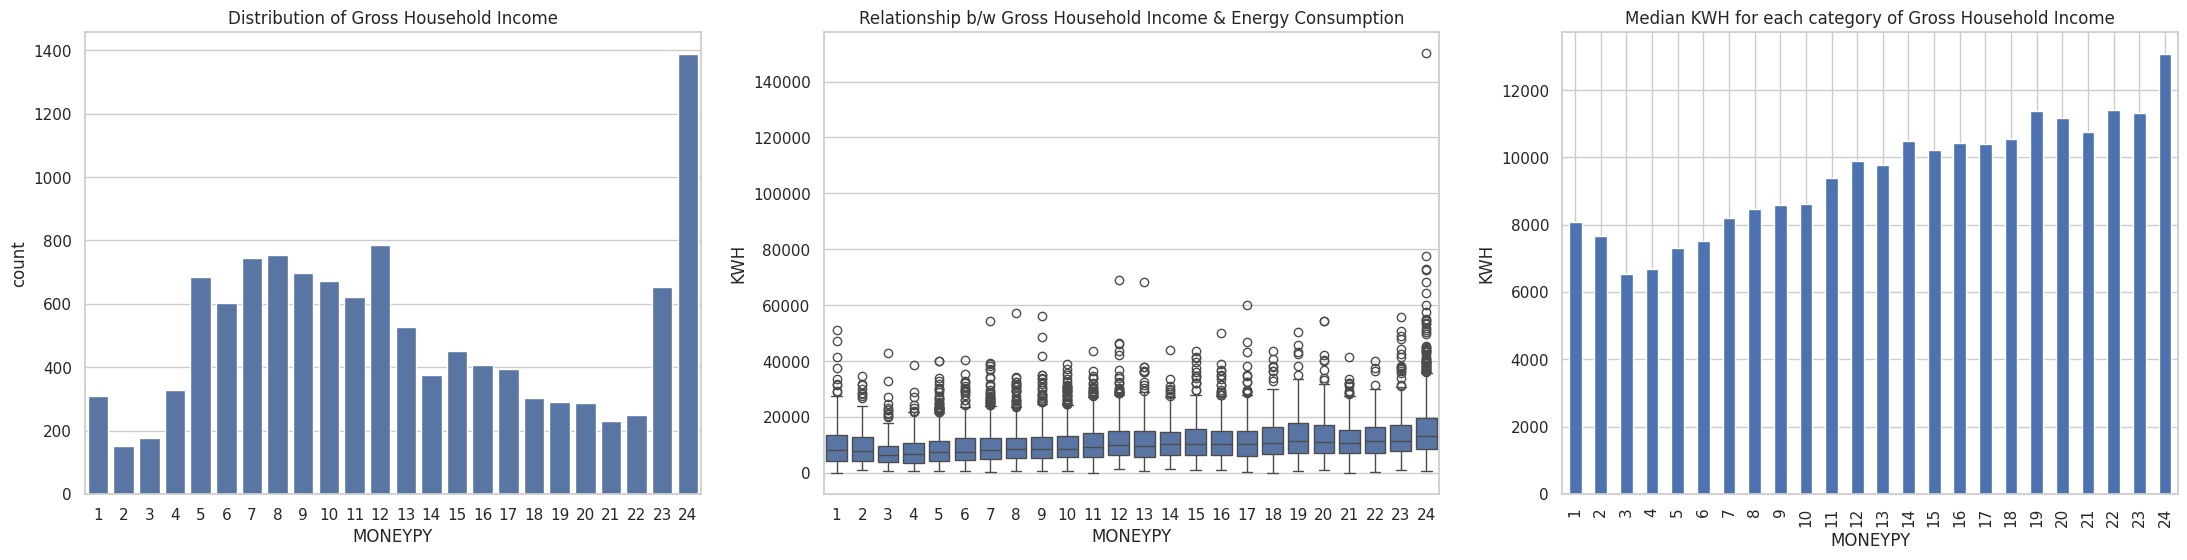

In [41]:
plt.figure(figsize=(27,6))
plt.subplot(1,3,1)
sns.set_style('whitegrid')
ax0 = sns.countplot(x='MONEYPY', data = df)
ax0.set_title('Distribution of Gross Household Income')
plt.subplot(1,3,2)
ax1 = sns.boxplot(x='MONEYPY', y ='KWH', data = df)
ax1.set_title('Relationship b/w Gross Household Income & Energy Consumption')
plt.subplot(1,3,3)
df.groupby('MONEYPY')['KWH'].median().plot.bar()
plt.title('Median KWH for each category of Gross Household Income')
plt.ylabel('KWH')

Based on the results of above bar plot, we can observe that very less number of households had less than \$10,000 as their gross household income (NOTE: factor/level 5 indicates gross household income of \$10,000 to \$14,999). The barplot and median KWH plot indicates higher energy consumption for households with gross income less than \$2,500 (depicted by factor/level 1) as compared to households with gross income between \$2,500 to \$19,999 (i.e. factor/level 2 to 6). This could be because of free electricity subsidy programs by state and federal government. However, for households with gross income greater than \$20,000, a clear pattern can be observed that as gross income of a household increase overall, the energy consumption increases as well

<a id="5"></a>
### 5. Data Transformation and Preprocessing

<a id="51"></a>
#### a. Data Transformation

<a id="511"></a>
##### i. Combining/Merging Predictor Features

Let's create a couple of new features by combining some of the existing features. These new features alongwith the existing ones will be later analyzed in feature selection section to determine whether keeping these features would help to understand our target variable better.

Here's the list of new features that will be created in this section:
- **TV Equipment Features:** We will merge all the TV equipment related features (such as TV, VCR, DVD, game console, home theatre, cable box and set-top box) and create a new feature called ALLTVFTR. The features that we will combine are ['TVCOLOR', 'CABLESAT1', 'COMBODVR1','DVR1', 'DIGITSTB1', 'PLAYSTA1', 'COMBOVCRDVD1', 'VCR1', 'DVD1', 'TVAUDIOSYS1', 'OTHERSTB1', 'CABLESAT2', 'COMBODVR2', 'DVR2', 'DIGITSTB2', 'PLAYSTA2', 'COMBOVCRDVD2', 'VCR2', 'DVD2', 'TVAUDIOSYS2', 'OTHERSTB2', 'CABLESAT3', 'COMBODVR3', 'DVR3', 'DIGITSTB3', 'PLAYSTA3', 'COMBOVCRDVD3', 'VCR3', 'DVD3', 'TVAUDIOSYS3', 'OTHERSTB3']

- **Office Equipment Features:** We will merge all the Office equipment related features (such as computer, monitor, printer, fax machine and cope machine) and create a new feature called ALLOFFFTR. The features that we will combine are ['NUMPC', 'PCPRINT', 'FAX', 'COPIER', 'MONITOR1', 'MONITOR2', 'MONITOR3']

- **Telephone Features:** We will merge all the telephone equipment related features (such as cordless telephone and answering machine) and create a new feature called ALLTELFTR. The features that we will combine are ['NOCORD', 'ANSMACH']

Let's just first start by replacing -2 value in all the above mentioned features to 0. Changing -2 to 0 in above features will ensure that we are not subtracting any value during the merging of these features. NOTE: None of the telephone features has -2 factor/level


In [42]:
tv_features = ['TVCOLOR', 'CABLESAT1', 'COMBODVR1','DVR1', 'DIGITSTB1', 'PLAYSTA1', 'COMBOVCRDVD1', 'VCR1', 'DVD1', 'TVAUDIOSYS1', 'OTHERSTB1', 'CABLESAT2', 'COMBODVR2', 'DVR2',
'DIGITSTB2', 'PLAYSTA2', 'COMBOVCRDVD2', 'VCR2', 'DVD2', 'TVAUDIOSYS2', 'OTHERSTB2', 'CABLESAT3', 'COMBODVR3', 'DVR3', 'DIGITSTB3', 'PLAYSTA3', 'COMBOVCRDVD3', 'VCR3', 'DVD3',
'TVAUDIOSYS3', 'OTHERSTB3']
office_features = ['NUMPC', 'PCPRINT', 'FAX', 'COPIER', 'MONITOR1', 'MONITOR2', 'MONITOR3']
tel_features = ['NOCORD', 'ANSMACH']

for i in tv_features:
    df[i] = df[i].apply(lambda x : x if x != -2 else 0)
df['ALLTVFTR'] = df[tv_features].sum(axis=1)

for i in office_features:
    df[i] = df[i].apply(lambda x : x if x != -2 else 0)
df['ALLOFFFTR'] = df[office_features].sum(axis=1)

df['ALLTELFTR'] = df[tel_features].sum(axis=1)

<a id="512"></a>
##### ii. Combining/Merging Levels with Low Frequency in Discrete Predictor Features

In the [Explore Additional Predictor Variables](#g-explore-additional-predictor-variables) section of EDA, we observed that some of the discrete numeric variables 'Total Rooms in Housing (TOTROOMS) and 'Total Members in Household' (NHSLDMEM) had only few data observations beyond a specific factor value. Hence, we will merge some of the levels for these variables due to the low frequency of values for these levels. In particular, for feature TOTROOMS, we will merge values 15 to 23 and create a new level 12 which would imply 'More than 14 Rooms'. For feature NHSLDMEM, we will merge values 6 to 14 to create a new level 6 which would mean 'More than 5 Members'

In [43]:
df['TOTROOMS'] = df['TOTROOMS'].replace([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [12]*12)
df['NHSLDMEM'] = df['NHSLDMEM'].replace([6, 7, 8, 9, 10, 11, 12, 13, 14], [6]*9)

Let's verify whether the levels have been merged or not

In [44]:
print(df['TOTROOMS'].describe(), df['TOTROOMS'].value_counts())

count    12083.000000
mean         5.980468
std          2.124759
min          1.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         12.000000
Name: TOTROOMS, dtype: float64 TOTROOMS
6     2369
5     2199
7     1784
4     1766
8     1296
3      862
9      716
10     375
1      216
11     173
2      169
12     158
Name: count, dtype: int64


In [45]:
print(df['NHSLDMEM'].describe(), df['NHSLDMEM'].value_counts())

count    12083.000000
mean         2.631631
std          1.404977
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max          6.000000
Name: NHSLDMEM, dtype: float64 NHSLDMEM
2    4052
1    2785
3    2070
4    1749
5     859
6     568
Name: count, dtype: int64


<a id="52"></a>
#### b. Data Preprocessing

<a id="521"></a>
##### i. Removing Predictor Features with high 'Not Applicable' Values

Previosuly, in the [Check for Missing Values](#d-check-for-missing-values) section of EDA we found 72 features with 'Not Applicable' values in more than 95% of the observations (i.e. less variability in the data values since >95% of observations are same value -2 i.e. NA). And these features were also checked for their correlation with our target variable and thus on the basis of high NA values and very weak correlation with target variable, we concluded that these 72 features have negligible amount of predictive power over the outcome variable. Hence, we will now drop these features from our dataset.

In addition, in the [Summary Statistics](#c-summary-statistics) section of EDA, we also found two other features 'NOCRCASH' and 'NKRGALNC' to have more than 99% of the data values marked as -2 i.e. 'Not Applicable'. Hence, we will drop these features too since there is less variability in the data values and thus these features might not have any influence over the outcome variable

In [46]:
df.shape # let's print the shape before dropping above discussed 74 features

(12083, 944)

In [47]:
highNA_features = list(na_col_names.values)
highNA_features.extend(['NOCRCASH', 'NKRGALNC']) # adding two more features to the list of features with high NA values
print(len(highNA_features))

74


In [48]:
df.drop(highNA_features, axis = 1, inplace = True)

In [49]:
df.shape # let's print the shape after dropping above discussed 74 features.

(12083, 870)

<a id="522"></a>
##### ii. Removing Imputation Flags

All the features in our dataset starting with 'Z' are features representing imputation flags and we will now remove all of these features below.

In [50]:
# Let's make a list of all the features starting with 'Z'
Z_features = [col for col in df if col.startswith('Z')]
print('We have {} imputation flag features'.format(len(Z_features)))
print('-----'*38)
print('These features are: \n{}'.format(Z_features))

We have 359 imputation flag features
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
These features are: 
['ZKOWNRENT', 'ZCONDCOOP', 'ZYEARMADE', 'ZYEARMADERANGE', 'ZOCCUPYYRANGE', 'ZCONVERSION', 'ZORIG1FAM', 'ZLOOKLIKE', 'ZNUMFLRS', 'ZNUMAPTS', 'ZWALLTYPE', 'ZROOFTYPE', 'ZSTUDIO', 'ZNAPTFLRS', 'ZSTORIES', 'ZTYPEHUQ4', 'ZBEDROOMS', 'ZNCOMBATH', 'ZNHAFBATH', 'ZOTHROOMS', 'ZCELLAR', 'ZCRAWL', 'ZCONCRETE', 'ZBASEFIN', 'ZFINBASERMS', 'ZBASEHEAT', 'ZBASEHT2', 'ZPCTBSTHT', 'ZBASECOOL', 'ZBASECL2', 'ZPCTBSTCL', 'ZBASEUSE', 'ZATTIC', 'ZATTICFIN', 'ZFINATTRMS', 'ZATTCHEAT', 'ZATTCHT2', 'ZPCTATTHT', 'ZATTCCOOL', 'ZPCTATTCL', 'ZATTCCL2', 'ZATTICUSE', 'ZPRKGPLC1', 'ZSIZEOFGARAGE', 'ZGARGLOC', 'ZGARGHEAT', 'ZGARGCOOL', 'ZPRKGPLC2', 'ZSIZEOFDETACH', 'ZSTOVEN', 'ZSTOVENFUEL', 'ZSTOVE', 'ZSTOVEFUEL', 'ZOVEN', 'ZOVENFUEL', 'ZOVENUSE', 'ZOVENCLN', 'ZTYPECLN', 'ZM

In [51]:
df.shape # let's print the shape before dropping above mentioned 359 features.

(12083, 870)

In [52]:
df.drop(Z_features, axis = 1, inplace = True)

In [53]:
df.shape # let's print the shape after dropping the imputation flag features.

(12083, 511)

<a id="523"></a>
##### iii. Removing Duplicate Features

Previously, in the [Explore Target Variable and Extract Important Features](#e-explore-target-variable-and-extract-important-features) section of EDA, we found that some features present in the dataset to be duplicates such as KWH and BTUEL are both energy consumption features but in different units. Hence, we will drop all BTU features. In addition, we will drop price/cost features too since it is only consumption we are interested in. Moreover, cost is usually determined from the energy usage. Let's now make a list of all the BTU and DOL features that needs to be removed. Below is a list of all BTU, KWH and cost (columns with keyword DOL) related features. Some of these features were compiled by summing up one or more predictor features (as can be seen below:
)
- KWH = KWHSPH + KWHCOL + KWHWTH + KWHRFG + KWHOTH<br>
- BTUEL = BTUELSPH + BTUELCOL + BTUELWTH + BTUELRFG + BTUELOTH<br>
- DOLLAREL = DOLELSPH + DOLELCOL + DOLELWTH + DOLELRFG + DOLELOTH<br>
- CUFEETNG = CUFEETNGSPH + CUFEETNGWTH + CUFEETNGOTH<br>
- BTUNG = BTUNGSPH + BTUNGWTH + BTUNGOTH<br>
- DOLLARNG = DOLNGSPH + DOLNGWTH + DOLNGOTH<br>
- GALLONLP = GALLONLPSPH + GALLONLPWTH + GALLONLPOTH<br>
- BTULP = BTULPSPH + BTULPWTH + BTULPOTH<br>
- DOLLARLP = DOLLPSPH	+ DOLLPWTH + DOLLPOTH<br>
- GALLONFO = GALLONFOSPH + GALLONFOWTH + GALLONFOOTH<br>
- BTUFO = BTUFOSPH + BTUFOWTH + BTUFOOTH<br>
- DOLLARFO = DOLFOSPH + DOLFOWTH + DOLFOOTH<br>
- GALLONKER = GALLONKERSPH + GALLONKERWTH + GALLONKEROTH<br>
- BTUKER = BTUKERSPH + BTUKERWTH + BTUKEROTH<br>
- DOLLARKER = DOLKERSPH + DOLKERWTH + DOLKEROTH<br>
- TOTALBTU = TOTALBTUSPH + TOTALBTUCOL + TOTALBTUWTH + TOTALBTURFG + TOTALBTUOTH<br>
- TOTALDOL = TOTALDOLSPH + TOTALDOLCOL + TOTALDOLWTH + TOTALDOLRFG + TOTALDOLOTH<br>
- TOTALBTUSPH = BTUELSPH + BTUNGSPH + BTULPSPH + BTUFOSPH + BTUKERSPH<br>
- TOTALBTUCOL = BTUELCOL<br>
- TOTALBTUWTH = BTUELWTH + BTUNGWTH + BTULPWTH +  + BTUFOWTH + BTUKERWTH<br>
- TOTALBTURFG = BTUELRFG<br>
- TOTALBTUOTH = BTUELOTH + BTUNGOTH + BTULPOTH + BTUFOOTH + BTUKEROTH<br>
- TOTALDOLSPH = DOLELSPH + DOLNGSPH + DOLLPSPH + DOLFOSPH + DOLKERSPH<br>
- TOTALDOLCOL = DOLELCOL<br>
- TOTALDOLWTH = DOLELWTH + DOLNGWTH + DOLLPWTH + DOLFOWTH + DOLKERWTH<br>
- TOTALDOLRFG = DOLELRFG<br>
- TOTALDOLOTH = DOLELOTH + DOLNGOTH + DOLLPOTH + DOLFOOTH + DOLKEROTH<br>

In [54]:
BTU_features = [col for col in df if col.startswith('BTU')]
# Let's also add TOTALBTU features to this list
BTU_features.extend([col for col in df if col.startswith('TOTALBTU')])
print('We have {} BTU features'.format(len(BTU_features)))
print('-----'*38)
print('These features are: \n{}'.format(BTU_features))

We have 29 BTU features
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
These features are: 
['BTUEL', 'BTUELSPH', 'BTUELCOL', 'BTUELWTH', 'BTUELRFG', 'BTUELOTH', 'BTUNG', 'BTUNGSPH', 'BTUNGWTH', 'BTUNGOTH', 'BTULP', 'BTULPSPH', 'BTULPWTH', 'BTULPOTH', 'BTUFO', 'BTUFOSPH', 'BTUFOWTH', 'BTUFOOTH', 'BTUKER', 'BTUKERSPH', 'BTUKERWTH', 'BTUKEROTH', 'BTUWOOD', 'TOTALBTU', 'TOTALBTUSPH', 'TOTALBTUCOL', 'TOTALBTUWTH', 'TOTALBTURFG', 'TOTALBTUOTH']


In [55]:
df.shape # let's print the shape before dropping above mentioned 29 BTU features.

(12083, 511)

In [56]:
df.drop(BTU_features, axis = 1, inplace = True)

In [57]:
df.shape # let's print the shape after dropping the BTU features. Expected Shape:

(12083, 482)

Let's now make a list of all cost/price features i.e. features starting with keywords 'DOL' and 'TOTALDOL'

In [58]:
DOL_features = [col for col in df if col.startswith('DOL')]
# Let's also add TOTALDOL features to this list
DOL_features.extend([col for col in df if col.startswith('TOTALDOL')])
print('We have {} DOL or cost features'.format(len(DOL_features)))
print('-----'*38)
print('These features are: \n{}'.format(DOL_features))

We have 28 DOL or cost features
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
These features are: 
['DOLLAREL', 'DOLELSPH', 'DOLELCOL', 'DOLELWTH', 'DOLELRFG', 'DOLELOTH', 'DOLLARNG', 'DOLNGSPH', 'DOLNGWTH', 'DOLNGOTH', 'DOLLARLP', 'DOLLPSPH', 'DOLLPWTH', 'DOLLPOTH', 'DOLLARFO', 'DOLFOSPH', 'DOLFOWTH', 'DOLFOOTH', 'DOLLARKER', 'DOLKERSPH', 'DOLKERWTH', 'DOLKEROTH', 'TOTALDOL', 'TOTALDOLSPH', 'TOTALDOLCOL', 'TOTALDOLWTH', 'TOTALDOLRFG', 'TOTALDOLOTH']


In [59]:
df.shape # let's print the shape before dropping above mentioned 28 DOL features.

(12083, 482)

In [60]:
df.drop(DOL_features, axis = 1, inplace = True)

In [61]:
df.shape # let's print the shape after dropping the DOL features.

(12083, 454)

Let's now drop the features related to Wood usage, LPG/Propane usage, Natural Gas usage, Fuel Oil usage and Kerosene usage. In addition, we will also drop the following KWH features 'KWHSPH', 'KWHCOL', 'KWHWTH', 'KWHRFG', 'KWHOTH' since our target variable is KWH

In [62]:
othr_usage_features = ['KWHSPH', 'KWHCOL', 'KWHWTH', 'KWHRFG', 'KWHOTH', 'CUFEETNG', 'CUFEETNGSPH', 'CUFEETNGWTH', 'CUFEETNGOTH', 'GALLONLP', 'GALLONLPSPH',
'GALLONLPWTH', 'GALLONLPOTH', 'GALLONFO', 'GALLONFOSPH', 'GALLONFOWTH', 'GALLONFOOTH', 'GALLONKER', 'GALLONKERSPH', 'GALLONKERWTH', 'GALLONKEROTH', 'CORDSWD']

print('We have {} other usage and additional KWH features'.format(len(othr_usage_features)))
print('-----'*38)
print('These features are: \n{}'.format(othr_usage_features))

We have 22 other usage and additional KWH features
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
These features are: 
['KWHSPH', 'KWHCOL', 'KWHWTH', 'KWHRFG', 'KWHOTH', 'CUFEETNG', 'CUFEETNGSPH', 'CUFEETNGWTH', 'CUFEETNGOTH', 'GALLONLP', 'GALLONLPSPH', 'GALLONLPWTH', 'GALLONLPOTH', 'GALLONFO', 'GALLONFOSPH', 'GALLONFOWTH', 'GALLONFOOTH', 'GALLONKER', 'GALLONKERSPH', 'GALLONKERWTH', 'GALLONKEROTH', 'CORDSWD']


In [63]:
df.shape # let's print the shape before dropping above mentioned 22 other usage and additional KWH features.

(12083, 454)

In [64]:
df.drop(othr_usage_features, axis = 1, inplace = True)

In [65]:
df.shape # let's print the shape after dropping the other usage and additional KWH features.

(12083, 432)

Let's drop the feature DOEID as it is identifer rather than predictor. In addition, let's also drop NWEIGHT

In [66]:
df.drop(['DOEID', 'NWEIGHT'], axis = 1, inplace = True)
# Let's print the shape after droping these features.
df.shape

(12083, 430)

<a id="524"></a>
##### iv. Removing Outliers

Previously, in the [Explore Target Variable and Extract Important Features](#e-explore-target-variable-and-extract-important-features) section of EDA, we found that almost all the observations had KWH value under 80,000. Let's check how many observations in the dataset have KWH greater than 80,000 and accordingly handle these outlier values (if any)

In [67]:
# Let's check how many records have KWH > 80,000
print(f"Number of records that have more than 80000 KWH: {df[df.KWH > 80000].shape}")

Number of records that have more than 80000 KWH: (1, 430)


As we can see above, only one record has been found to have more than 80000 KWH value and in the previous section we saw that this oulier value of KWH was indeed very high to be true. Hence, we will now drop this row from our dataset

In [68]:
df2 = df[df.KWH <= 80000]
df2.shape

(12082, 430)

Let's also verify visually from boxplot whether this extreme outlier value has been excluded or not

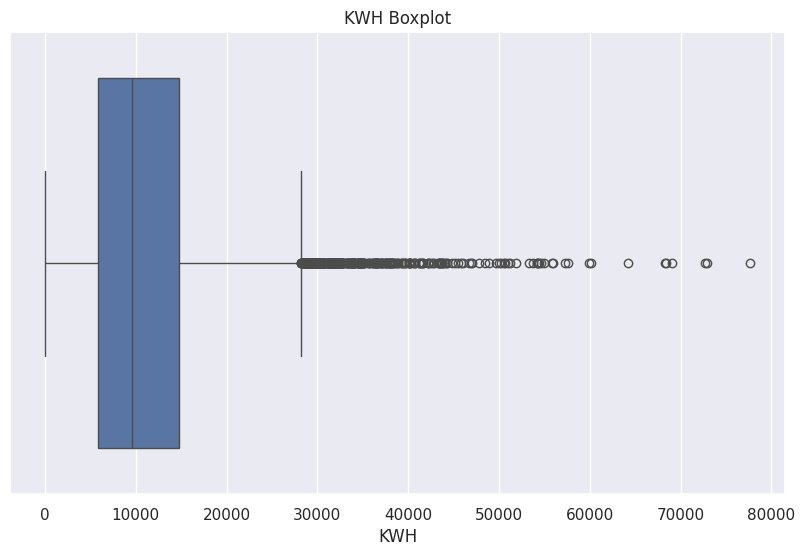

In [69]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.boxplot(x=df2['KWH']).set(title = 'KWH Boxplot')

<a id="6"></a>
### 6. Feature Engineering

<a id="61"></a>
#### a. Exploratory Feature Reduction

Let's use Principle Component Analysis (PCA), a feature reduction technique to see how many features can be used for data modeling. In other words, PCA is a technique to obtain important features from a large set of features which explains the most of the variability in the data. Let's start implementing PCA by first removing response variable from the dataset.

In [70]:
df_tmp = df2.drop(['KWH', 'KWHlog'], axis = 1)
df_tmp.shape

(12082, 428)

Let's use One-hot Encoding, a feature encoding strategy, first to convert our categorical features into a numerical feature

In [71]:
df_tmp = pd.get_dummies(df_tmp, columns= cat_features_remaining, drop_first = True)

In [72]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# Convert to numpy and scale
X = scale(df_tmp.values)

# Use a valid number of components (≤ min(n_samples, n_features))
pca = PCA(n_components=428)
pca.fit(X)


PCA(n_components=428)

In [73]:
var= pca.explained_variance_ratio_

Let's build a scree plot i.e. a line plot that shows the eigenvalues for each individual principal component. Scree plot helps us to access components or factors which explains the most of variability in the data. It represents values in descending order.

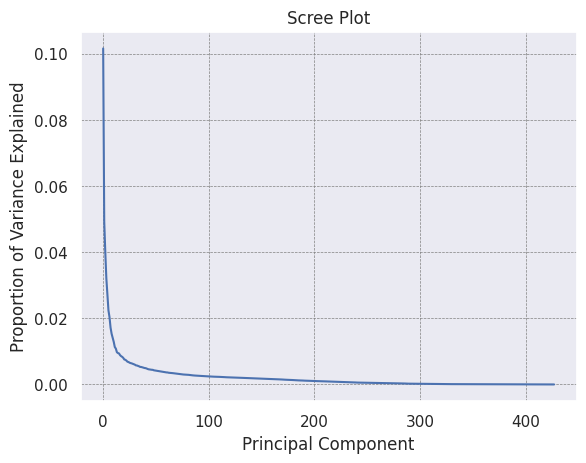

In [74]:
plt.grid(which='major', linestyle='--', linewidth='0.5', color='grey')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.plot(var)

The above scree plot indicates that approx. 20 principal components were able to capture most of the information.

In [75]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)

[10.16 15.08 19.08 22.29 24.99 27.23 29.26 30.98 32.51 33.92 35.21 36.34
 37.42 38.39 39.34 40.28 41.17 42.03 42.86 43.66 44.41 45.16 45.88 46.57
 47.25 47.91 48.56 49.2  49.82 50.43 51.03 51.61 52.18 52.74 53.29 53.82
 54.35 54.87 55.38 55.88 56.37 56.85 57.32 57.78 58.23 58.68 59.12 59.56
 59.99 60.41 60.83 61.24 61.65 62.05 62.45 62.84 63.22 63.6  63.97 64.34
 64.7  65.06 65.41 65.76 66.11 66.46 66.8  67.14 67.47 67.8  68.12 68.44
 68.76 69.07 69.38 69.69 69.99 70.29 70.59 70.88 71.17 71.46 71.75 72.03
 72.31 72.58 72.85 73.12 73.39 73.65 73.91 74.17 74.43 74.68 74.93 75.18
 75.43 75.68 75.93 76.18 76.42 76.66 76.9  77.14 77.38 77.61 77.84 78.07
 78.3  78.53 78.76 78.99 79.22 79.44 79.66 79.88 80.1  80.32 80.54 80.75
 80.96 81.17 81.38 81.59 81.8  82.01 82.22 82.42 82.62 82.82 83.02 83.22
 83.42 83.62 83.82 84.01 84.2  84.39 84.58 84.77 84.96 85.15 85.34 85.52
 85.7  85.88 86.06 86.24 86.42 86.6  86.78 86.95 87.12 87.29 87.46 87.63
 87.8  87.96 88.12 88.28 88.44 88.6  88.76 88.92 89

The above cumulative variance can be read as follows:
It shows that first principal component explains 10.1% variance. The first and second component cumulatively explains 15.05% variance or we can say that second principal component alone explains 4.95% variance. First, second and third component cumulatively explains 19.05% variance and so on. Let's now plot cumulative variance

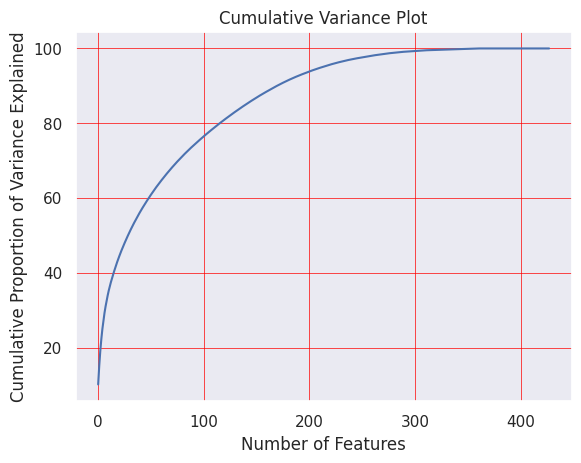

In [76]:
# cumulative scree plot
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.title('Cumulative Variance Plot')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.plot(var1)

The above plot shows that ~ 200 features result in variance close to ~ 95%. The PCA analysis gives us a ballpark estimate of the number of features that explains majority of the variation in the dataset and hence can be used for data modeling. However, let's use Gradient Boosting Machine (GBM) in the later [Feature Selection](#) section to automatically calculate feature importance

<a id="62"></a>
#### b. Feature Selection

I am going to use a pre built `FeatureSelector` class made available by Will Koehrsen on their [GitHub](https://github.com/WillKoehrsen/feature-selector/blob/master/feature_selector/feature_selector.py). This `FeatureSelector` includes the following most common feature selection methods:

- Features with a high percentage of missing values
- Collinear (highly correlated) features
- Features with zero importance in a tree-based model
- Features with low importance
- Features with a single unique value

Earlier, during the EDA phase of the project, we found that there were indeed no missing values in the RECS 2009 dataset. Hence, the `FeatureSelector` class that we are going to utilize for Feature Selection phase of the project, we are only going to use the last four common feature selection methods. Let's now start by finding features with single unique value

<a id="621"></a>
##### i. Find Features with Single Unique Value


In [77]:
labels = df2['KWH']
data_fs = df2.drop(columns = ['KWH', 'KWHlog'])

In [78]:
fs = FeatureSelector(data = data_fs, labels = labels) # Let's inititate the class FeatureSelector()

In [79]:
fs.identify_single_unique()
single_unique = fs.ops['single_unique']
single_unique

['USEEL']

As we can see above, we just have one feature 'USEEL' in the entire set of 441 features with single unique value. Let's now check the collinear features in our dataset. Collinear features can be defined as the features that are highly correlated with one another. In practice, we exclude the features which are highly correlated as including a pair of such features can lead to decrease in model performance on test set.

<a id="622"></a>
##### ii. Find Collinear Features

In [80]:
fs.identify_collinear(correlation_threshold=0.98)
correlated_features = fs.ops['collinear']
print('----------------------------------------------------------------------------------------')
print('These features are: \n{}'.format(correlated_features))

----------------------------------------------------------------------------------------
These features are: 
['HDD30YR', 'NAPTFLRS', 'ATTCHEAT', 'ATTCCOOL', 'ATTICUSE', 'GARGHEAT', 'GARGCOOL', 'NUMFREEZ', 'UPRTFRZR', 'FREEZER', 'INTERNET', 'STEAMR', 'PIPELESS', 'AUTOHEATDAY', 'DNTAC', 'THERMAINAC', 'AUTOCOOLDAY', 'TEMPGONEAC', 'TEMPNITEAC', 'ELCOOL', 'PELHEAT', 'PELHOTWA', 'PELCOOK', 'PELAC', 'PGASHEAT', 'PGASHTWA', 'PUGCOOK', 'FOPAY', 'WOODLOGS', 'WDSCRAP', 'WDPELLET', 'WDOTHER', 'TOTSQFT_EN', 'SCALEEL', 'SCALENG', 'SCALELP', 'SCALEFO', 'UR_U']


Let's now plot all the correlations which were found to be above threshold using correlation heatmap of the correlation values

In [81]:
features = list(set(fs.record_collinear['corr_feature']).union(set(fs.record_collinear['drop_feature'])))
valid_features = [f for f in features if f in df2.columns]
corr_mat_plt = df2[valid_features].corr()

Let's also check which pair of features were found to be correlated with each other and their respective correlation values

In [82]:
fs.record_collinear

,drop_feature,corr_feature,corr_value
0,HDD30YR,HDD65,0.990868
1,NAPTFLRS,STUDIO,0.981555
2,ATTCHEAT,ATTICFIN,0.991812
3,ATTCCOOL,ATTICFIN,0.990083
4,ATTCCOOL,ATTCHEAT,0.997023
5,ATTICUSE,ATTICFIN,0.987224
6,ATTICUSE,ATTCHEAT,0.993245
7,ATTICUSE,ATTCCOOL,0.994419
8,GARGHEAT,GARGLOC,0.982768
9,GARGCOOL,GARGLOC,0.987641


<a id="623"></a>
##### iii. Find Features with Zero Importance using GBM

In [83]:
fs.identify_zero_importance(task = 'regression', eval_metric = 'l2', n_iterations = 10, early_stopping = False)
print('----------------------------------------------------------------------------------------')
print('These features are: \n{}'.format(fs.ops['zero_importance']))

----------------------------------------------------------------------------------------
These features are: 
['CONDCOOP', 'CONVERSION', 'NUMFLRS', 'CELLAR', 'CONCRETE', 'BASEFIN', 'BASEHEAT', 'BASECL2', 'ATTIC', 'ATTICFIN', 'ATTCHEAT', 'ATTCCOOL', 'ATTICUSE', 'GARGHEAT', 'STOVEN', 'STOVE', 'OVENCLN', 'TYPECLN', 'MICRO', 'AMTMICRO', 'TOPGRILL', 'REPLCFRI', 'HELPFRZ', 'DISHWASH', 'CWASHER', 'RNSETEMP', 'DRYER', 'AGECDRYER', 'CABLESAT1', 'PLAYSTA1', 'TVAUDIOSYS1', 'OTHERSTB1', 'TVONWEWATCH1', 'CABLESAT2', 'COMBODVR2', 'DIGITSTB2', 'COMBOVCRDVD2', 'OTHERSTB2', 'TVONWDWATCH2', 'TVONWEWATCH2', 'DIGITSTB3', 'DVD3', 'TVAUDIOSYS3', 'OTHERSTB3', 'COMPUTER', 'PCTYPE1', 'PCONOFF1', 'PCONOFF2', 'MONITOR3', 'PCONOFF3', 'INTERNET', 'COPIER', 'SWAMPCOL', 'STEREO', 'NOCORD', 'BATTOOLS', 'ELECCHRG', 'HEATHOME', 'MAINTHT', 'EQUIPAGE', 'HEATOTH', 'STEAMR', 'PIPELESS', 'ROOMHEAT', 'CARRYEL', 'CARRYKER', 'CHIMNEY', 'NGFPFLUE', 'RANGE', 'DIFEQUIP', 'THERMAIN', 'AUTOHEATNITE', 'AUTOHEATDAY', 'NUMH2ONOTNK', '

The above method of feature selection has been designed for machine learning problem. Using Gradient Boosting Machine learning model from the [LightGBM Library](https://lightgbm.readthedocs.io/en/v3.3.2/), we tried to find the features from our dataset which have zero importance. These features were averaged over 10 training runs in order to reduce variance. As we can observe from the above results, 28 features were found to have zero importance and we can remove these features later on without affecting model performance.

Let's now check how many features have a cumulative importance of 90% and also see the top 20 features in order of their importance.

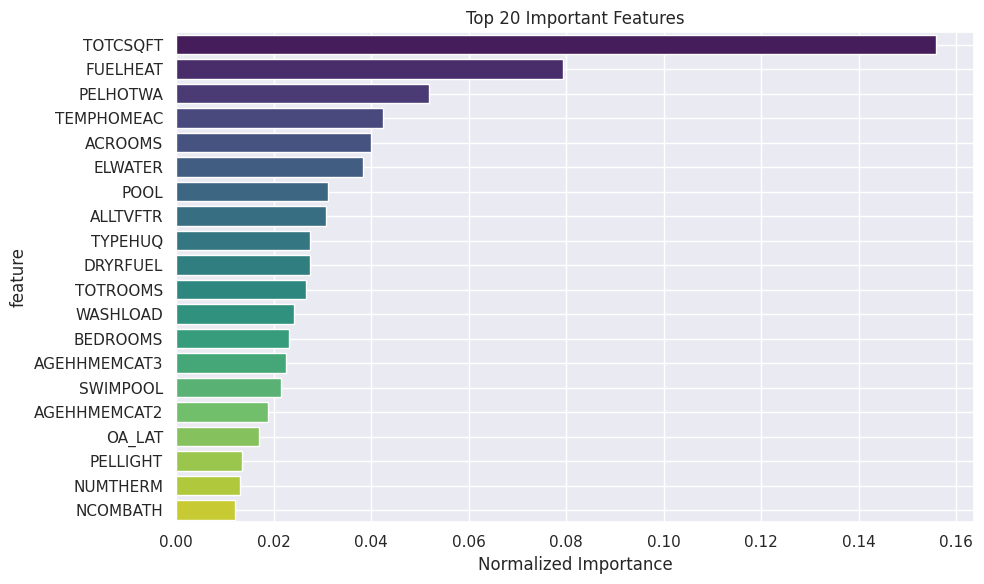

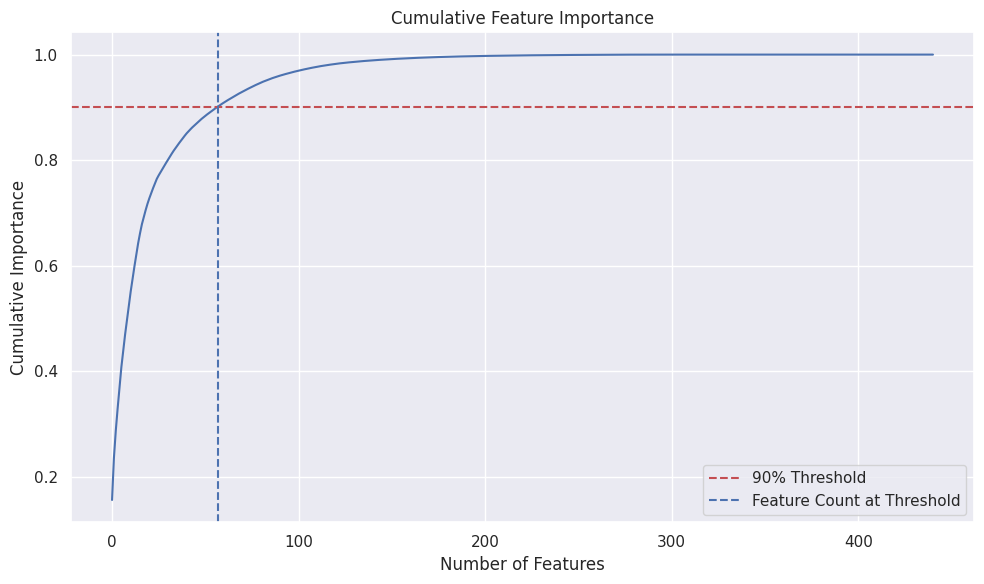

In [84]:
fs.plot_feature_importances(threshold = 0.9, plot_n = 20)

As can be seen from the first plot, among the top 20 features (plotted in terms of normalized importance), the top five of them are YEARMADE, HHAGE, TOTCSQFT, CDD80 and CDD30YR. The plot at the bottom shows cumulative importance ploteed on y-axis and number of features on x-axis. The vertical dotted line is drawn at the threshold value of cumulative importance we chose above i.e. 90%. We can notice that 225 features are required for 90% of the cumulative importance.

In [85]:
top_features = list(fs.feature_importances.loc[:224, 'feature'])
print(top_features)

['REGIONC', 'DIVISION', 'REPORTABLE_DOMAIN', 'TYPEHUQ', 'HDD65', 'CDD65', 'HDD30YR', 'CDD30YR', 'Climate_Region_Pub', 'AIA_Zone', 'KOWNRENT', 'CONDCOOP', 'YEARMADE', 'YEARMADERANGE', 'OCCUPYYRANGE', 'CONVERSION', 'NUMFLRS', 'NUMAPTS', 'WALLTYPE', 'ROOFTYPE', 'STUDIO', 'NAPTFLRS', 'STORIES', 'BEDROOMS', 'NCOMBATH', 'NHAFBATH', 'OTHROOMS', 'TOTROOMS', 'CELLAR', 'CRAWL', 'CONCRETE', 'BASEFIN', 'FINBASERMS', 'BASEHEAT', 'BASEHT2', 'PCTBSTHT', 'BASECOOL', 'BASECL2', 'BASEUSE', 'ATTIC', 'ATTICFIN', 'ATTCHEAT', 'ATTCCOOL', 'ATTICUSE', 'PRKGPLC1', 'SIZEOFGARAGE', 'GARGLOC', 'GARGHEAT', 'GARGCOOL', 'PRKGPLC2', 'SIZEOFDETACH', 'OUTLET', 'STOVEN', 'STOVENFUEL', 'STOVE', 'STOVEFUEL', 'OVEN', 'OVENFUEL', 'OVENUSE', 'OVENCLN', 'TYPECLN', 'MICRO', 'AMTMICRO', 'DEFROST', 'OUTGRILL', 'OUTGRILLFUEL', 'TOPGRILL', 'TOASTER', 'NUMMEAL', 'FUELFOOD', 'COFFEE', 'NUMFRIG', 'TYPERFR1', 'SIZRFRI1', 'REFRIGT1', 'ICE', 'AGERFRI1', 'ESFRIG', 'REPLCFRI', 'HELPFRI', 'TYPERFR2', 'SIZRFRI2', 'REFRIGT2', 'MONRFRI2', 'AG

<a id="624"></a>
##### iv. Find Features with Low Importance

Let's now find the lowest importance features that do not contribute to a specified total importance. Recall that when finding important features in the section above, we used a cumulative importance threshold of 90%. Let's use the same threshold value to find the least important features that are not required to achieve 90% of total importance

In [86]:
fs.identify_low_importance(cumulative_importance = 0.90)

['RECBATH',
 'NUMH2OHTRS',
 'REPORTABLE_DOMAIN',
 'DesignDBT99',
 'TIMEON2',
 'OVEN',
 'TOTUSQFT',
 'PELAC',
 'WHEATSIZ',
 'OUTGRILL',
 'UR_U',
 'TOTSQFT',
 'HHAGE',
 'ALLOFFFTR',
 'ICE',
 'HEATROOM',
 'AIA_Zone',
 'TVONWE2',
 'TEMPNITEAC',
 'STUDIO',
 'LGT12EE',
 'WALLTYPE',
 'MAINTAC',
 'LGT1',
 'TEMPGONEAC',
 'PGASHTWA',
 'TVONWD1',
 'TIMEON1',
 'YEARMADE',
 'TVSIZE1',
 'REFRIGT2',
 'NUMFRIG',
 'OTHROOMS',
 'DOOR1SUM',
 'WELLPUMP',
 'AQUARIUM',
 'PRKGPLC2',
 'NAPTFLRS',
 'STORIES',
 'SCALEEL',
 'DRAFTY',
 'PUGOTH',
 'HELPFRI',
 'UPRTFRZR',
 'NGASLIGHT',
 'WINDOWS',
 'EQUIPM',
 'HDD65',
 'HELPCAC',
 'OCCUPYYRANGE',
 'PRKGPLC1',
 'DIVISION',
 'USENOTMOIST',
 'CASHBEN',
 'USECFAN',
 'TELLDAYS',
 'AGEHHMEMCAT5',
 'TOTUCSQFT',
 'HELPWS',
 'WSF',
 'HBUSNESS',
 'GWT',
 'EDUCATION',
 'TVONWE3',
 'TVONWE1',
 'TVAUDIOSYS2',
 'PERIODEL',
 'LGTOEE',
 'HDD30YR',
 'DesignDBT1',
 'MONEYPY',
 'TVONWD3',
 'TVONWD2',
 'KAVALEL',
 'PERMELEC',
 'HELPHT',
 'PCSLEEP2',
 'CDD65',
 'AGERFRI2',
 'REGIONC',


As you can notice, based on the cumulative importance threshold value of 90%, the gradient boosting machine considers 217 features to be not relevant for model learning purpose.
<a id="625"></a>
##### v. Removing Features

Using above four methods in [Feature Selection](#b-feature-selection), we identifed which features to drop. Now' let's drop all these features

In [87]:
data_fs_removed = fs.remove(methods = 'all')

In [88]:
print(list(data_fs_removed.columns))
print(len(data_fs_removed.columns))

['TYPEHUQ', 'CDD30YR', 'Climate_Region_Pub', 'METROMICRO', 'UR', 'BEDROOMS', 'NCOMBATH', 'TOTROOMS', 'OUTGRILLFUEL', 'SIZRFRI2', 'MONRFRI2', 'SEPFREEZ', 'SIZFREEZ', 'AGEFRZR', 'DWASHUSE', 'WASHLOAD', 'DRYRFUEL', 'TVCOLOR', 'FUELHEAT', 'NUMTHERM', 'TEMPGONE', 'TEMPNITE', 'FUELH2O', 'ACROOMS', 'USECENAC', 'TEMPHOMEAC', 'USEWWAC', 'NUMCFAN', 'SWIMPOOL', 'POOL', 'FUELTUB', 'LGT12', 'LGT4', 'NOUTLGTNT', 'USENG', 'ELWARM', 'ELWATER', 'ELFOOD', 'PELLIGHT', 'NHSLDMEM', 'AGEHHMEMCAT2', 'AGEHHMEMCAT3', 'AGEHHMEMCAT4', 'TOTHSQFT', 'TOTCSQFT', 'KAVALNG', 'PERIODNG', 'IECC_Climate_Pub', 'HDD50', 'CDD80', 'OA_LAT', 'ALLTVFTR']
52


Let's remove the one hot encoding features from the above `data_fs_removed` dataframe i.e. we will remove all the columns which were categorical in nature and were converted to one hot encodings during the process of feature selection. These columns are METROMICRO_METRO, UR_R and IECC_Climate_Pub_3A. The reason we are doing this is because we ran feature selection on the entire training set without separating the test set. In reality, while training the model, we would separate the dataset into two subsets, training and test. The training set will be further divided into two splits during cross validation, training and validation fold, and we don't have any information beforehand whether we would have categories in the test data that were not in the training data. Usually, if such case arise, an error will occur. In addition, another way to think about this is considering the deployment stage of the model. There is a chance that the data distributions in future might change and we might get new categories in our categorical data features and the model prediction will result in error if there are new categories in the dataset. Hence, we would use the `ColumnTransformer` inside the `Pipelines` in the later section of model development to handle the categorical features.

However, it's worth mentioning here that of all the categories of the categorical features, only three, METROMICRO_METRO, UR_R and IECC_Climate_Pub_3A, were found to be important features by the `FeatureSelector` class

In [94]:
data_fs_removed.shape

(12082, 52)

Now, let's add original categorical feature names to the list of columns of data_fs_removed

In [95]:
print('Original Number of Features', data_fs.shape[1])
print('Final Number of Features: ', data_fs_removed.shape[1])

Original Number of Features 428
Final Number of Features:  52


Let's append our target variable column to final_columns list

In [96]:
final_columns = list(data_fs_removed.columns)
final_columns.append("KWH")

<a id="7"></a>
### 7. Model Development & Comparison
<a id="71"></a>
#### a. Building Baseline Models with default params

In [97]:
final_data = df2[final_columns]
final_data.shape

(12082, 53)

In [98]:
# Separate features and labels
y = final_data['KWH']
X = final_data.drop(columns =['KWH'])

We could train a model using all the data we have; however it is a common practice in supervised machine learning to split into two subsets; a larger set with which to train the model, and a smaller holdout data set (also called test set) to provide an unbiased evaluation of a final model fit on the training data set.

Next we do the train-test split and hold out the test set until we decide our final model

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 8457 rows
Test Set: 3625 rows


In [100]:
print(f'X_train shape is:{X_train.shape} \nX_test shape is:{X_test.shape}\ny_train shape is:{y_train.shape}\ny_test shape is:{y_test.shape}')

X_train shape is:(8457, 52) 
X_test shape is:(3625, 52)
y_train shape is:(8457,)
y_test shape is:(3625,)


Next, we normalize the numeric features using `StandardScaler()` to transform our feature data such that its distribution will have a mean value 0 and standard deviation of 1. Normalizing is an important step in machine learning as it brings all the features on the same scale and thus prevents features with large values from producing coefficients that disproportionately affect the predictions. In addition to scaling transformation, we also need to apply one hot encoding to our categorical features to convert categories into numbers since scikit-learn only accepts numeric data as input. We will make use of `ColumnTransformer` by defining the separate preprocessing pipelines, each for numeric and categorical features.

We will then wrap the column transformer in another pipeline containing our regressor using the `Pipeline` utility available in sklearn and finally use this pipeline inside `cross_validate`

In [101]:
numeric_features = X_train.select_dtypes('number').columns
categorical_features = X_train.select_dtypes('object').columns

In [102]:
numeric_transformer = Pipeline(
    steps = [("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps = [("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

col_transformer = ColumnTransformer(
    transformers = [
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)
]
)

#### Train Baseline Models with Default Params

Now we start training baseline model using default hyperparameters. We will use cross validation process in model training. If we were to fit the model with the training set while evaluated with the test set, we obtained only a single sample point of evaluation with one test set. How can we be sure it is an accurate evaluation, rather than a value too low or too high by chance? If we have two models, and found that one model is better than another based on the evaluation, how can we know this is also not by chance?

Hence, we make use of cross validation to evaluate each model multiple times with different dataset and take the average score for our decision to choose the final model candidate for evaluation on holdout dataset or test dataset. __Cross validation__ uses k-fold to resample the same dataset multiple times and pretend they are different. With cross validation, as we are evaluating the model, or hyperparameter, the model has to be trained from scratch, each time, without reusing the training result from previous attempts.

In [103]:
pipeline = []
pipeline.append(("Linear Regression", Pipeline([("preprocessor", col_transformer), ("LR", LinearRegression())])))
pipeline.append(("Lasso", Pipeline([("preprocessor", col_transformer), ('Lasso', Lasso())])))
pipeline.append(("Ridge", Pipeline([("preprocessor", col_transformer), ('Ridge', Ridge())])))
pipeline.append(("ElasticNet", Pipeline([("preprocessor", col_transformer), ('eNet', ElasticNet())])))
pipeline.append(("RForest", Pipeline([("preprocessor", col_transformer), ('RF', RandomForestRegressor())])))
pipeline.append(("Gradient Boosting", Pipeline([("preprocessor", col_transformer), ('GBM', GradientBoostingRegressor())])))
pipeline.append(("XG Boost", Pipeline([("preprocessor", col_transformer), ('xgb', xgb.XGBRegressor(objective = "reg:squarederror"))])))

Let's define the scoring criteria by selecting:
- __Root Mean Square Error (RMSE):__ The square root of the mean of the squared difference between predicted and actual values. This yields an absolute metric in the same unit as the label (in this case, Electricity Consumption in KWH). The smaller the value, the better the model is (i.e. in a simplistic sense, it represents the average electricity consumption by which the predictions are wrong!)

- __Coefficient of Determination (usually known as R-squared or R2):__ Higher the value of this metric, the better the fit of the model is. This metric represents how much of the variance between predicted and actual label values the model is able to explain. The R-squared metric might not be considered to be a good metric in our case because R-square value increases artificially as the number of features increases. Hence, we will set RMSE to be the main scoring criteria later in the hyperparameter tuning section

You may use other metrics for evaluation regression models. Refer this [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

In [104]:
RMSE = []
R2 = []
names = []
scoring = {'rmse': 'neg_root_mean_squared_error',
           'r2': 'r2'
           }

In [105]:
for name, model in pipeline:
    kfold = KFold(n_splits = 5, random_state = 1, shuffle = True)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs = 1)
    RMSE.append(cv_results['test_rmse']*-1)
    R2.append(cv_results['test_r2'])
    names.append(name)

In [106]:
avg_RMSE = [sum(i)/len(i) for i in RMSE]
avg_R2 = [sum(j)/len(j) for j in R2]
model_baseline_metrics = pd.DataFrame({
                                            'Model': names,
                                            'Baseline_AvgRMSE': avg_RMSE,
                                            'Baseline_AvgR2': avg_R2
                                        })
model_baseline_metrics

,Model,Baseline_AvgRMSE,Baseline_AvgR2
0,Linear Regression,4755.727072,0.603885
1,Lasso,4755.363784,0.603955
2,Ridge,4755.515105,0.603921
3,ElasticNet,4879.115754,0.583615
4,RForest,4645.892478,0.622414
5,Gradient Boosting,4528.510041,0.640836
6,XG Boost,4755.191895,0.604128


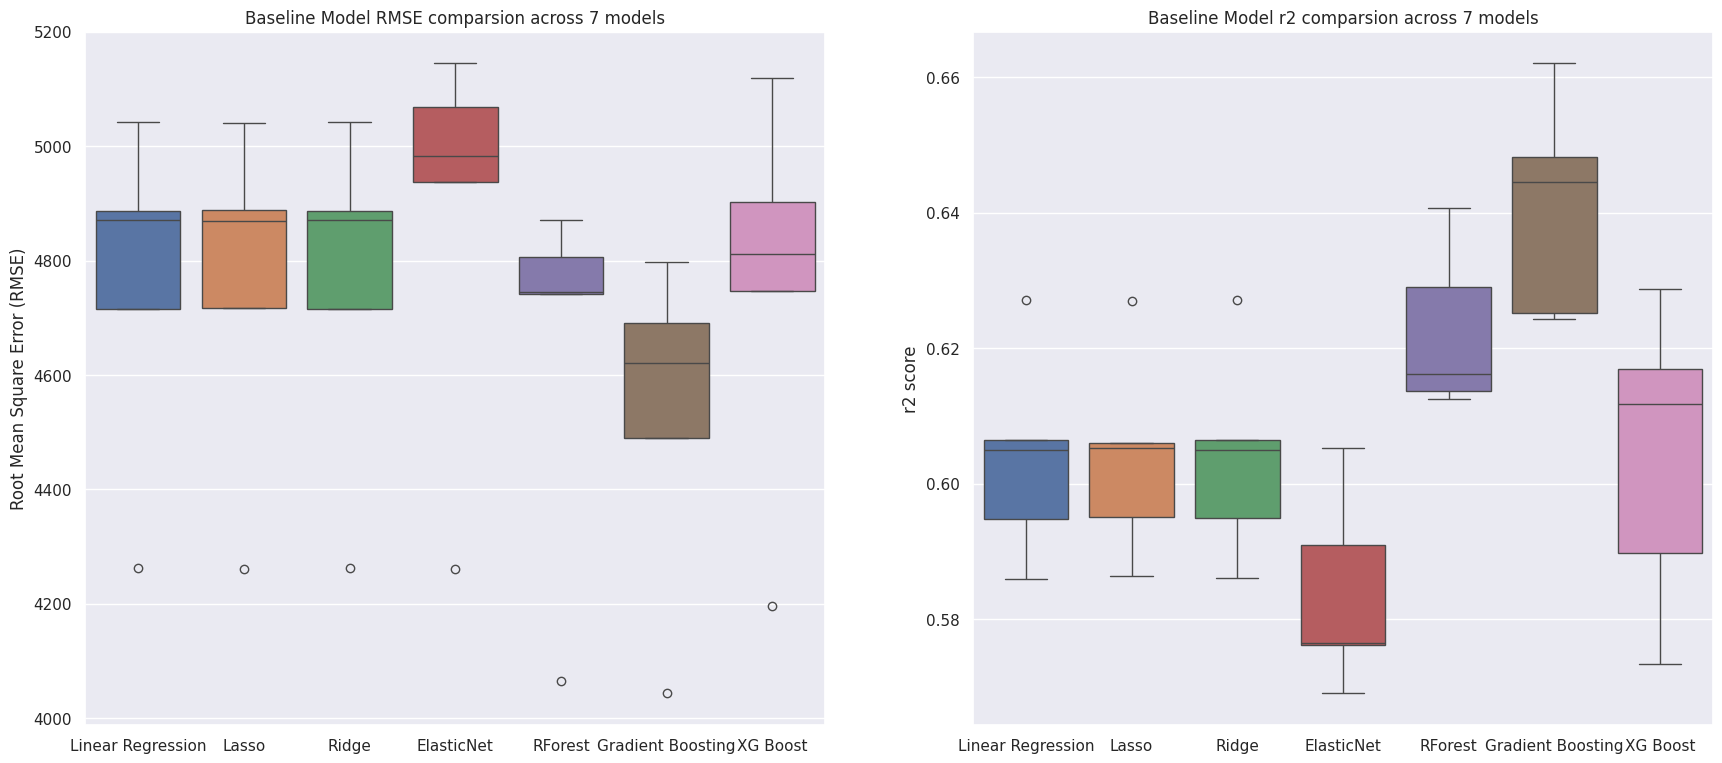

In [107]:
plt.figure(figsize=(21,9))

ax1 = plt.subplot(1,2,1)
sns.boxplot(data = RMSE)
ax1.set_xticklabels(names)
ax1.set_ylabel("Root Mean Square Error (RMSE)")
ax1.set_title("Baseline Model RMSE comparsion across 7 models")

ax2 = plt.subplot(1,2,2)
sns.boxplot(data = R2)
ax2.set_xticklabels(names)
ax2.set_ylabel("r2 score")
ax2.set_title("Baseline Model r2 comparsion across 7 models")

plt.show()

Above, we evaluated each of the models multiple times with different dataset using cross validation process. From the dataframe and box plots above, we can see that the baseline models more or less perform similar. Let's re-run cross validation after tuning the model hyperparameters

<a id="72"></a>
#### b. Hyperparameter Tuning & Model Comparison

In [108]:
pipeline_tuned_models = []
pipeline_tuned_models.append(("Lasso", Pipeline([("preprocessor", col_transformer), ('Lasso', Lasso(random_state = 123))])))
pipeline_tuned_models.append(("Ridge", Pipeline([("preprocessor", col_transformer), ('Ridge', Ridge(random_state = 123))])))
pipeline_tuned_models.append(("ElasticNet", Pipeline([("preprocessor", col_transformer), ('eNet', ElasticNet(random_state = 123))])))
pipeline_tuned_models.append(("RForest", Pipeline([("preprocessor", col_transformer), ('RF', RandomForestRegressor(random_state = 123))])))
pipeline_tuned_models.append(("Gradient Boosting", Pipeline([("preprocessor", col_transformer), ('GBM', GradientBoostingRegressor(random_state = 123))])))
pipeline_tuned_models.append(("XG Boost", Pipeline([("preprocessor", col_transformer), ('xgb', xgb.XGBRegressor(objective = "reg:squarederror", random_state = 123))])))

Next, we define hyperparameters we want to tune for each of the models. Note: We only tuned few hyperparameters; however if you are not constrained by computational resources you may try more hyperparameters or more settings of hyperparameters to tune

In [109]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['Lasso__alpha'] = np.linspace(0, 0.2, 21)

param2 = {}
param2['Ridge__alpha'] = np.linspace(0, 0.2, 21)

param3 = {}
param3['eNet__max_iter'] = [1, 5, 10]
param3['eNet__alpha'] = np.linspace(0, 0.2, 21)
param3['eNet__l1_ratio'] = np.arange(0.0, 1.0, 0.1)

param4 = {}
param4['RF__n_estimators'] = [50, 100, 150]
max_depth = [5, 10, 15]       ##[int(x) for x in np.linspace(5, 15, num = 3)]
max_depth.append(None)
param4['RF__max_depth'] = max_depth
param4['RF__min_samples_split'] = [2, 5, 10]
# param4['min_samples_leaf'] = [5, 10, 15]  ## if you have enough computing respurces, you could try to tune more hyperparameters by uncommenting these lines
# param4['bootstrap'] = [True, False]
param4['RF__max_features'] = [1, 'sqrt']
# param4['max_leaf_nodes'] = [5, 10, 15]

param5 = {}
param5['GBM__learning_rate'] = [0.01, 0.05, 0.1, 1.0]
param5['GBM__n_estimators'] = [50, 100, 150]

param6 = {}
param6['xgb__learning_rate'] = [0.01, 0.05, 0.1]
param6['xgb__n_estimators'] = [100, 300, 600, 900]
param6['xgb__max_depth'] = [8]
param6['xgb__subsample'] = [0.7]
param6['xgb__colsample_bytree'] = [0.9]
param6['xgb__verbosity'] = [0]

In [110]:
params = [param1, param2, param3, param4, param5, param6]
names_tunedmodels = []
best_params = []
best_score = []
best_estimator = []
avg_RMSE = []
RMSE_tunedmodels = []
avg_R2 = []
R2_tunedmodels = []
for param, (name_t, pipe) in zip(params, pipeline_tuned_models):
    gridsearch = GridSearchCV(pipe, param_grid=param, scoring=scoring, cv=5, n_jobs=-1, refit='rmse', verbose=1)
    gridsearch.fit(X_train, y_train)
    best_params.append(gridsearch.best_params_)
    best_score.append(gridsearch.best_score_)
    best_estimator.append(gridsearch.best_estimator_)
    avg_RMSE.append(np.mean(gridsearch.cv_results_['mean_test_rmse']*-1))
    avg_R2.append(np.mean(gridsearch.cv_results_['mean_test_r2']))
    RMSE_tunedmodels.append(gridsearch.cv_results_['mean_test_rmse']*-1)
    R2_tunedmodels.append(gridsearch.cv_results_['mean_test_r2'])
    names_tunedmodels.append(name_t)
list_of_models = list(zip(names_tunedmodels, best_params, best_estimator, best_score, avg_RMSE, avg_R2))
df_models_tuned = pd.DataFrame(list_of_models, columns = ['Model', 'best_params', 'best_estimator', 'best_score_rmse', 'AvgRMSE', 'AvgR2'])
df_models_tuned

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 630 candidates, totalling 3150 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


,Model,best_params,best_estimator,best_score_rmse,AvgRMSE,AvgR2
0,Lasso,{'Lasso__alpha': 0.2},"(ColumnTransformer(transformers=[('numeric',\n...",-4764.184679,4764.385610,0.602255
1,Ridge,{'Ridge__alpha': 0.2},"(ColumnTransformer(transformers=[('numeric',\n...",-4764.504257,4764.730413,0.602196
2,ElasticNet,"{'eNet__alpha': 0.04, 'eNet__l1_ratio': 0.0, '...","(ColumnTransformer(transformers=[('numeric',\n...",-4797.492603,5009.778278,0.559270
3,RForest,"{'RF__max_depth': None, 'RF__max_features': 's...","(ColumnTransformer(transformers=[('numeric',\n...",-4626.867627,5014.621031,0.558018
4,Gradient Boosting,"{'GBM__learning_rate': 0.1, 'GBM__n_estimators...","(ColumnTransformer(transformers=[('numeric',\n...",-4519.332429,5229.327049,0.514580
5,XG Boost,"{'xgb__colsample_bytree': 0.9, 'xgb__learning_...","(ColumnTransformer(transformers=[('numeric',\n...",-4463.637891,4640.798861,0.622014


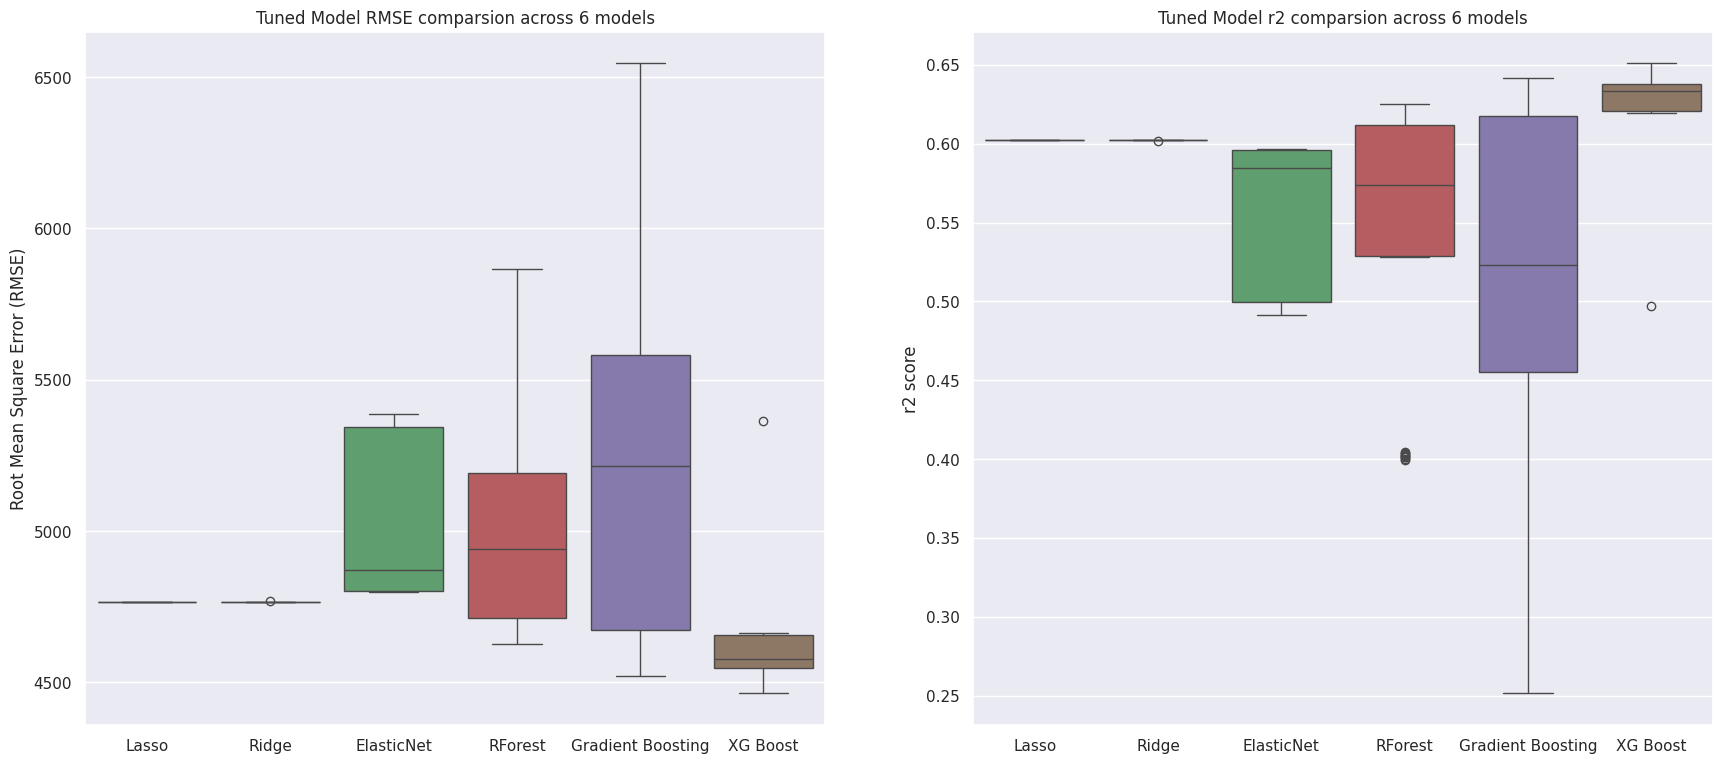

In [111]:
plt.figure(figsize=(21,9))

ax1 = plt.subplot(1,2,1)
sns.boxplot(data = RMSE_tunedmodels)
ax1.set_xticklabels(names_tunedmodels)
ax1.set_ylabel("Root Mean Square Error (RMSE)")
ax1.set_title("Tuned Model RMSE comparsion across 6 models")

ax2 = plt.subplot(1,2,2)
sns.boxplot(data = R2_tunedmodels)
ax2.set_xticklabels(names_tunedmodels)
ax2.set_ylabel("r2 score")
ax2.set_title("Tuned Model r2 comparsion across 6 models")

plt.show()

From the above rsult of cross validation using `GridSearchCV` (refer dataframe and box plots above), we can clearly see that the tree based models (i.e. Gradient Boosting Regressor and Xtreme Gradient Boosting XGB) have better RMSE compared to linear models. However; XGB model has the lowest RMSE in comparison to Gradient Boosting Regressor. Hence, we may conclude that XGB is better than GBM. For now, since XGB model is better than other models, we will retrain the model again using the set of best parameters of XGB that `GridSearchCV` found.

The reason for retraining the model is that during the cross validation we do not have a lot of data, and the smaller dataset we used previously, had a part of it held out for validation. We believe that combining the training and validation dataset can produce a better model. Hence, we retrain the model of the entire training dataset this time and evaluate the model on our holdout dataset i.e. test dataset. Because this is unseen data, it can help us evaluate the generalization, or out-of-sample, error. This should simulate what the model will do when we deploy it. We do not expect this evaluation score to be very different from that we obtained from cross validation in the previous step, if we did the model training correctly. This can serve as a confirmation for our model selection.

__NOTE:__ The dataset for evaluation on test dataset, and the one we used in cross validation, are different because we do not want data leakage. If they were the same, we would see the same score as we have already seen from the cross validation. After retraining the model, we will use test dataset. Since we used refit = 'rmse' inside `GridSearchCV`, the best estimator has already been refitted using the best found parameters on the whole training dataset. As a next step, we just need to call predict on `gridsearch.best_estimator_` using X_test dataset i.e. holdout because the 'best_estimator' is a pipeline containing both the `ColumnTransformer` and the trained model that had the best score.

<a id="73"></a>
#### c. Model Evaluation on Unseen Data

In [112]:
# Get Predictions
predictions = gridsearch.best_estimator_.predict(X_test)

# Display Metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 19410132.0
RMSE: 4405.693135024272
R2: 0.6508443355560303


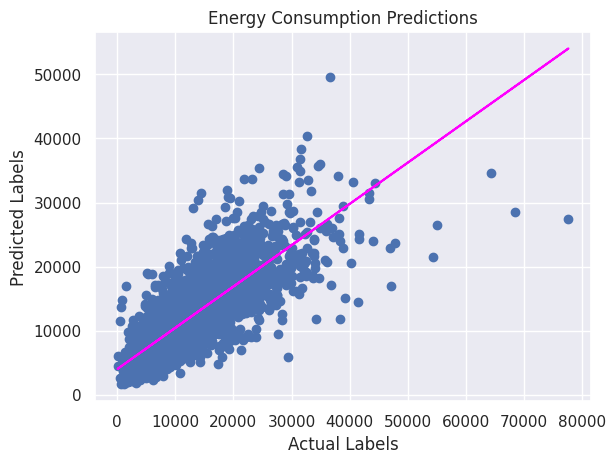

In [113]:
# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Energy Consumption Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [115]:
import os
import joblib

# Ensure 'models/' folder exists
os.makedirs("models", exist_ok=True)

# Save the model
filename = 'models/xgb.pkl'
joblib.dump(gridsearch.best_estimator_, filename)


['models/xgb.pkl']